In [ ]:
%pip install torch-geometric
%pip install pynvml

In [2]:
import os
import math
import time
import copy
import psutil
import pynvml
import random
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as nn_utils

from torch.nn import Sequential, Linear, ReLU, Sigmoid, Tanh, Dropout, LeakyReLU
from torch.nn.modules.module import Module
from torch.distributions import normal, kl

import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool, BatchNorm, EdgePooling, TopKPooling, global_add_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_absolute_error, jaccard_score

from scipy.linalg import norm
from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(42)

using cuda


# Data Preprocessing

In [3]:
# dataset_path = '/Users/gitaayusalsabila/Documents/0thesis/code/sandbox/dataset/'
dataset_path = '/notebooks/dataset/'


def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

def check_and_drop_invalid_graphs(graph_dataset):
    num_graphs, num_timepoints, num_nodes, _ = graph_dataset.shape
    num_dimensions = 1
    
    valid_graphs = []

    for i in range(num_graphs):
        is_valid = True
        for t in range(num_timepoints):
            adj_matrix = graph_dataset[i, t, :, :]
            num_edges = np.sum(adj_matrix > 0)
            if num_edges == 0:
                is_valid = False
                break
        
        if is_valid:
            valid_graphs.append(i)
    
    cleaned_dataset = graph_dataset[valid_graphs, :, :, :]
    
    return cleaned_dataset

def split_data(adj_data, features_data, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2, random_seed=None):
    assert adj_data.shape[0] == features_data.shape[0], "Adjacency and features data must have the same number of samples"
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "The sum of train, val and test ratios must be 1"

    num_samples = adj_data.shape[0]
    indices = np.arange(num_samples)
    if random_seed is not None:
        np.random.seed(random_seed)
    np.random.shuffle(indices)

    train_end = int(train_ratio * num_samples)
    val_end = train_end + int(val_ratio * num_samples)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    adj_train = torch.tensor(adj_data[train_indices], dtype=torch.float32)
    adj_val = torch.tensor(adj_data[val_indices], dtype=torch.float32)
    adj_test = torch.tensor(adj_data[test_indices], dtype=torch.float32)

    features_train = torch.tensor(features_data[train_indices], dtype=torch.float32)
    features_val = torch.tensor(features_data[val_indices], dtype=torch.float32)
    features_test = torch.tensor(features_data[test_indices], dtype=torch.float32)

    return adj_train, adj_val, adj_test, features_train, features_val, features_test


## Simulated Dataset
simulated_adj = np.load(dataset_path + 'simulated_adj.npy')
simulated_adj = simulated_adj[:, :, :, :,0] #only take the domain 1
simulated_features = np.load(dataset_path + 'simulated_laplacian_features.npy')
simulated_features = simulated_features[:, :, :, :,0]
simulated_num_samples, simulated_num_time, simulated_num_nodes, simulated_num_features = simulated_features.shape 
print(f'Simulated Dataset: Number of Samples= {simulated_num_samples},  Number of Times= {simulated_num_time}, Number of Nodes= {simulated_num_nodes}, Number of Features= {simulated_num_features}')
simulated_adj_train, simulated_adj_val, simulated_adj_test, simulated_features_train, simulated_features_val, simulated_features_test = split_data(simulated_adj, simulated_features)

## OASIS Dataset
oasis = np.load(dataset_path + 'oasis_adj.npy')
oasis_cleaned = data_cleansing(oasis)
oasis_adj = check_and_drop_invalid_graphs(oasis_cleaned)
oasis_features = np.load(dataset_path + 'oasis_laplacian_features.npy') 
oasis_num_samples, oasis_num_time, oasis_num_nodes, oasis_num_features = oasis_features.shape 
print(f'OASIS Dataset: Number of Samples= {oasis_num_samples},  Number of Times= {oasis_num_time}, Number of Nodes= {oasis_num_nodes}, Number of Features= {oasis_num_features}')
oasis_adj_train, oasis_adj_val, oasis_adj_test, oasis_features_train, oasis_features_val, oasis_features_test = split_data(oasis_adj, oasis_features)

## EMCI-AD Dataset
emci = np.load(dataset_path + 'emci-ad_adj.npy')
emci_cleaned = data_cleansing(emci)
emci_adj = check_and_drop_invalid_graphs(emci_cleaned)
emci_features = np.load(dataset_path + 'emci-ad_laplacian_features.npy') 
emci_num_samples, emci_num_time, emci_num_nodes, emci_num_features = emci_features.shape 
print(f'EMCI-AD Dataset: Number of Samples= {emci_num_samples},  Number of Times= {emci_num_time}, Number of Nodes= {emci_num_nodes}, Number of Features= {emci_num_features}')
emci_adj_train, emci_adj_val, emci_adj_test, emci_features_train, emci_features_val, emci_features_test = split_data(emci_adj, emci_features)

## SLIM160 Dataset
slim160 = np.load(dataset_path + 'slim160_adj.npy')
slim160_cleaned = data_cleansing(slim160)
slim160_adj = check_and_drop_invalid_graphs(slim160_cleaned)
slim160_features = np.load(dataset_path + 'slim160_laplacian_features_8.npy') 
slim160_num_samples, slim160_num_time, slim160_num_nodes, slim160_num_features = slim160_features.shape 
print(f'SLIM160 Dataset: Number of Samples= {slim160_num_samples},  Number of Times= {slim160_num_time}, Number of Nodes = {slim160_num_nodes}, Number of Features = {slim160_num_features}')
slim160_adj_train, slim160_adj_val, slim160_adj_test, slim160_features_train, slim160_features_val, slim160_features_test = split_data(slim160_adj, slim160_features)

Simulated Dataset: Number of Samples= 100,  Number of Times= 3, Number of Nodes= 35, Number of Features= 8
OASIS Dataset: Number of Samples= 114,  Number of Times= 3, Number of Nodes= 35, Number of Features= 8
EMCI-AD Dataset: Number of Samples= 67,  Number of Times= 2, Number of Nodes= 35, Number of Features= 8
SLIM160 Dataset: Number of Samples= 109,  Number of Times= 3, Number of Nodes = 160, Number of Features = 8


In [4]:
def vectorize(M):
    return M[np.tril_indices(M.shape[0], k=-1)]

def create_edge_index_attribute(adj_matrix):
    rows, cols = adj_matrix.shape[0], adj_matrix.shape[1]
    edge_index = torch.zeros((2, rows * cols), dtype=torch.long)
    edge_attr = torch.zeros((rows * cols, 1), dtype=torch.float)
    counter = 0

    for src, attrs in enumerate(adj_matrix):
        for dest, attr in enumerate(attrs):
            edge_index[0][counter], edge_index[1][counter] = src, dest
            edge_attr[counter] = attr
            counter += 1

    return edge_index, edge_attr, rows, cols

def plot_heatmaps_each_timepoint(input_adj, ground_truth_adj, reconstructed_adj, residual_adj, time_point):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].imshow(input_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[0].set_title(f'Input Graph at Time {time_point}')

    ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[1].set_title(f'Ground Truth Graph at Time {time_point+1}')

    ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[2].set_title(f'Generated Graph at Time {time_point+1}')

    ax[3].imshow(residual_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[3].set_title(f'Residual Graph at Time {time_point+1}')

    plt.show()

def plot_heatmaps_across_timepoints(input_adj, ground_truth_adj, reconstructed_adj, time_point):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    cax0 = ax[0].imshow(input_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[0].set_title(f'Graph at Time {time_point}')
    fig.colorbar(cax0, ax=ax[0])

    cax1 = ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[1].set_title(f'Graph at Time {time_point+1}')
    fig.colorbar(cax1, ax=ax[1])

    cax2 = ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[2].set_title(f'Residual Graph between Time {time_point} and {time_point+1}')
    fig.colorbar(cax2, ax=ax[2])

    plt.show()


# Identity Mapper

In [5]:
def evaluate_identity(adj_test):
    num_test_samples = adj_test.shape[0]
    num_roi = adj_test.shape[2]
    num_time_points = adj_test.shape[1]

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_ns = []  # Node Strength
    mae_cc = []  # Clustering Coefficient
    frobenius_distances = []

    pred_1d_list = []
    gt_1d_list = []

    pred_matrices_all = []
    gt_matrices_all = []

    for i in range(num_test_samples):
        set_seed(42)
        
        # Predict adjacency matrix at time point t-1
        recon_adj_t_1= adj_test[i, 0]
        pred_matrices_all.append(recon_adj_t_1.cpu().numpy())
        adj_t_gt_1 = adj_test[i, 1]  
        gt_matrices_all.append(adj_t_gt_1.cpu().numpy())
        
        pred_1d_list.append(vectorize(recon_adj_t_1.cpu().numpy()))
        gt_1d_list.append(vectorize(adj_t_gt_1.cpu().numpy()))

        if num_time_points > 2:
            # Predict adjacency matrix at time point t-1
            recon_adj_t_2= adj_test[i, 1]
            pred_matrices_all.append(recon_adj_t_2.cpu().numpy())
            adj_t_gt_2 = adj_test[i, 2]  
            gt_matrices_all.append(adj_t_gt_2.cpu().numpy())

            pred_1d_list.append(vectorize(recon_adj_t_2).cpu().numpy())
            gt_1d_list.append(vectorize(adj_t_gt_2).cpu().numpy())
    
    
    for i in range(len(pred_matrices_all)):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices_all[i])
        gt_graph = nx.from_numpy_array(gt_matrices_all[i])

        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight", max_iter=1000, tol=1e-3)
        pred_ns = dict(pred_graph.degree(weight="weight")).values()
        pred_cc = nx.clustering(pred_graph, weight="weight")

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight", max_iter=1000, tol=1e-3)
        gt_ns = dict(gt_graph.degree(weight="weight")).values()
        gt_cc = nx.clustering(gt_graph, weight="weight")

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_ns_values = list(pred_ns)
        pred_cc_values = list(pred_cc.values())

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_ns_values = list(gt_ns)
        gt_cc_values = list(gt_cc.values())

        # Compute MAEs for centrality measures
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_ns.append(mean_absolute_error(pred_ns_values, gt_ns_values))
        mae_cc.append(mean_absolute_error(pred_cc_values, gt_cc_values))

        # Compute Frobenius distance
        frobenius_distances.append(norm(pred_matrices_all[i] - gt_matrices_all[i], 'fro'))
        
    # Compute average MAEs and distances
    avg_mae_bc = np.mean(mae_bc)
    avg_mae_ec = np.mean(mae_ec)
    avg_mae_ns = np.mean(mae_ns)
    avg_mae_cc = np.mean(mae_cc)
    avg_frobenius_distance = np.mean(frobenius_distances)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute overall MAE
    mae = mean_absolute_error(pred_1d, gt_1d)

    print(f"MAE: {mae:.4f}")
    print(f"Average Frobenius distance: {avg_frobenius_distance:.4f}")
    print(f"Average MAE node strength: {avg_mae_ns:.4f}")
    print(f"Average MAE clustering coefficient: {avg_mae_cc:.4f}")
    print(f"Average MAE betweenness centrality: {avg_mae_bc:.4f}")
    print(f"Average MAE eigenvector centrality: {avg_mae_ec:.4f}")
    return 

## Simulated

In [6]:
evaluate_identity(simulated_adj_test)

MAE: 0.0422
Average Frobenius distance: 1.9704
Average MAE node strength: 0.7090
Average MAE clustering coefficient: 0.0581
Average MAE betweenness centrality: 0.2719
Average MAE eigenvector centrality: 0.0273


## OASIS

In [7]:
evaluate_identity(oasis_adj_test)

MAE: 0.0523
Average Frobenius distance: 2.6079
Average MAE node strength: 0.9510
Average MAE clustering coefficient: 0.0410
Average MAE betweenness centrality: 0.0862
Average MAE eigenvector centrality: 0.0233


## EMCI-AD

In [8]:
evaluate_identity(emci_adj_test)

MAE: 0.0860
Average Frobenius distance: 3.9414
Average MAE node strength: 1.3765
Average MAE clustering coefficient: 0.0101
Average MAE betweenness centrality: 0.1051
Average MAE eigenvector centrality: 0.0048


## SLIM160

In [9]:
evaluate_identity(slim160_adj_test)

MAE: 0.1450
Average Frobenius distance: 31.2412
Average MAE node strength: 10.2748
Average MAE clustering coefficient: 0.0557
Average MAE betweenness centrality: 0.0286
Average MAE eigenvector centrality: 0.0270


# RBGM

In [21]:
def eucledian_distance(x, target_size):
  repeated_out = x.repeat(target_size,1,1)
  repeated_t = torch.transpose(repeated_out, 0, 1)
  diff = torch.abs(repeated_out - repeated_t)
  return torch.sum(diff, 2)

def frobenious_distance(test_sample,predicted):
  diff = torch.abs(test_sample - predicted)
  dif = diff*diff
  sum_of_all = diff.sum()
  d = torch.sqrt(sum_of_all)
  return d


## Model
class RNNCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_state):
        super(RNNCell, self).__init__()
        self.weight = nn.Linear(input_dim, hidden_dim, bias=True)
        self.weight_h = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.out = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.tanh = Tanh()
        self.hidden_state = hidden_state
    
    def forward(self,x):
        h = self.hidden_state
        y = self.tanh(self.weight(x.to(device)) + self.weight_h(h))
        self.hidden_state = y.detach()
        return y

class RBGM(nn.Module):
    def __init__(self, conv_size, hidden_state_size):
        super(RBGM, self).__init__()
        shape = torch.Size((hidden_state_size, hidden_state_size))
        hidden_state = torch.rand(shape, device=device)
        self.conv_size = conv_size
        self.rnn = nn.Sequential(RNNCell(1,hidden_state_size, hidden_state), ReLU())
        self.gnn_conv = NNConv(self.conv_size, self.conv_size, self.rnn, aggr='mean', root_weight=True, bias = True)
        
    def forward(self, data):
        edge_index, edge_attr, _, _ = create_edge_index_attribute(data)
        x1 = F.relu(self.gnn_conv(data, edge_index.to(device), edge_attr.to(device)))
        x1 = eucledian_distance(x1, self.conv_size)
        return x1

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)



def train_rbgm(model_1, model_2, train_adj, val_adj, num_epochs=200, lr=0.0001, 
               save_path='models/RBGM/rbgm_model', tp_c=10, patience=5, gradient_clip=1.0, step_size=50, gamma=0.1):
    
    # Initialize loss functions and optimizers
    mael = torch.nn.L1Loss().to(device)
    tp = torch.nn.MSELoss().to(device)

    optimizer_1 = optim.Adam(model_1.parameters(), lr=lr)
    optimizer_2 = optim.Adam(model_2.parameters(), lr=lr)

    # Learning rate schedulers
    scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1, step_size=step_size, gamma=gamma)
    scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=step_size, gamma=gamma)

    # Track losses and resource usage
    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    model_1.to(device)
    model_2.to(device)
    process = psutil.Process()

    for epoch in range(num_epochs):
        total_loss_1, total_loss_2 = 0.0, 0.0
        tp_loss_1, tp_loss_2, gen_loss_1, gen_loss_2 = 0.0, 0.0, 0.0, 0.0
        
        set_seed(42)
        model_1.train()
        model_2.train()

        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0
        
        for i in range(train_adj.size(0)):
            data = train_adj[i]
            num_time_points = data.size(0)

            for t in range(num_time_points - 1):
                data_t = data[t]
                data_t_next = data[t + 1]
                
                # Time Point t
                optimizer_1.zero_grad()
                out_1 = model_1(data_t.to(device))
                
                tpl_1 = tp(out_1.sum(dim=-1), data_t_next.sum(dim=-1))
                tp_loss_1 += tpl_1.item()
                genl_1 = mael(out_1, data_t_next)
                gen_loss_1 += genl_1.item()
                
                loss_1 = genl_1 + tp_c * tpl_1
                total_loss_1 += loss_1.item()
                loss_1.backward()
                
                nn_utils.clip_grad_norm_(model_1.parameters(), gradient_clip)  # Gradient Clipping
                optimizer_1.step()
                
                if t < num_time_points - 2:
                    # Time Point t+1
                    optimizer_2.zero_grad()
                    out_2 = model_2(data_t_next.to(device))
                    
                    data_t_next_next = data[t + 2] if t + 2 < num_time_points else data_t_next
                    tpl_2 = tp(out_2.sum(dim=-1), data_t_next_next.sum(dim=-1))
                    tp_loss_2 += tpl_2.item()
                    
                    genl_2 = mael(out_2, data_t_next_next)
                    gen_loss_2 += genl_2.item()
                    
                    loss_2 = genl_2 + tp_c * tpl_2
                    total_loss_2 += loss_2.item()
                    loss_2.backward()
                    
                    nn_utils.clip_grad_norm_(model_2.parameters(), gradient_clip)  # Gradient Clipping
                    optimizer_2.step()
        
        scheduler_1.step()  # Step the learning rate schedulers
        scheduler_2.step()

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)

        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during the epoch
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        # Compute average losses
        epoch_loss = (total_loss_1 + total_loss_2) / train_adj.size(0)
        epoch_gen_loss = (gen_loss_1 + gen_loss_2) / train_adj.size(0)
        epoch_tp_loss = (tp_loss_1 + tp_loss_2) / train_adj.size(0)
        training_loss.append(epoch_loss)
        
        print(f'Epoch {epoch + 1}:\n  Training -> Loss: {epoch_loss}, Generative Loss: {epoch_gen_loss}, Topological Loss: {epoch_tp_loss}')

        # Validation step
        model_1.eval()
        model_2.eval()
        val_loss_1, val_loss_2 = 0.0, 0.0
        val_tp_loss_1, val_tp_loss_2, val_gen_loss_1, val_gen_loss_2 = 0.0, 0.0, 0.0, 0.0
        
        with torch.no_grad():
            for i in range(val_adj.size(0)):
                data = val_adj[i]
                num_time_points = data.size(0)

                for t in range(num_time_points - 1):
                    data_t = data[t]
                    data_t_next = data[t + 1]

                    # Time Point t
                    out_1 = model_1(data_t.to(device))
                    
                    tpl_1 = tp(out_1.sum(dim=-1), data_t_next.sum(dim=-1))
                    val_tp_loss_1 += tpl_1.item()
                    genl_1 = mael(out_1, data_t_next)
                    val_gen_loss_1 += genl_1.item()
                    
                    loss_1 = genl_1 + tp_c * tpl_1
                    val_loss_1 += loss_1.item()
                    
                    if t < num_time_points - 2:
                        # Time Point t+1
                        out_2 = model_2(data_t_next.to(device))
                        
                        data_t_next_next = data[t + 2] if t + 2 < num_time_points else data_t_next
                        tpl_2 = tp(out_2.sum(dim=-1), data_t_next_next.sum(dim=-1))
                        val_tp_loss_2 += tpl_2.item()
                        
                        genl_2 = mael(out_2, data_t_next_next)
                        val_gen_loss_2 += genl_2.item()
                        
                        loss_2 = genl_2 + tp_c * tpl_2
                        val_loss_2 += loss_2.item()

        # Compute average validation losses
        val_loss = (val_loss_1 + val_loss_2) / val_adj.size(0)
        val_gen_loss = (val_gen_loss_1 + val_gen_loss_2) / val_adj.size(0)
        val_tp_loss = (val_tp_loss_1 + val_tp_loss_2) / val_adj.size(0)
        validation_loss.append(val_loss)

        print(f'  Validation -> Loss: {val_loss:.4f}, Generative Loss: {val_gen_loss:.4f}, Topological Loss: {val_tp_loss:.4f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model_1.state_dict(), save_path + '_model_1.pth')
            torch.save(model_2.state_dict(), save_path + '_model_2.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break
        
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage_percent[-1]:.2f}%, Memory: {memory_usage[-1]:.2f}GB, GPU: {gpu_usage[-1]:.2f}GB, GPU Util: {gpu_usage_percent[-1]:.2f}%\n')

    # Plot the training and validation loss
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    print(f'Average Time per Epoch: {np.mean(epoch_time):.2f}s')
    print(f'Average CPU Usage: {np.mean(cpu_usage_percent):.2f}%')
    print(f'Average Memory Usage: {np.mean(memory_usage):.2f}GB')
    print(f'Average GPU Usage: {np.mean(gpu_usage):.2f}GB')
    print(f'Average GPU Utilization: {np.mean(gpu_usage_percent):.2f}%')

    print(f'\nTotal Training Time: {np.sum(epoch_time):.2f}s')
    print(f'Max CPU Usage: {np.max(cpu_usage_percent):.2f}%')
    print(f'Max Memory Usage: {np.max(memory_usage):.2f}GB')
    print(f'Max GPU Usage: {np.max(gpu_usage):.2f}GB')
    print(f'Max GPU Utilization: {np.max(gpu_usage_percent):.2f}%')

    return

def inference_rbgm(model_1, model_2, adj, sample_idx=0):
    # Load the saved model
    model_1.eval()
    model_2.eval()

    # Perform inference
    with torch.no_grad():
        # Generate graph at time point 1 given graph at time point 0
        recon_adj_1 = model_1(adj[sample_idx, 0])
        residual_adj_1 = recon_adj_1 - adj[sample_idx, 1]
        mse_residual_adj_1 = np.mean(np.square(residual_adj_1.cpu().detach().numpy()))
        print("Mean Squared Error between predicted (t1) and ground truth graphs (t0): ", mse_residual_adj_1)
        plot_heatmaps_each_timepoint(adj[sample_idx, 0], adj[sample_idx, 1], recon_adj_1, residual_adj_1, 0)

        if adj.shape[1] > 2:  # Check if there is a second time point
            # Generate graph at time point 2 given graph at time point 1
            recon_adj_2 = model_2(adj[sample_idx, 1])
            residual_adj_2 = recon_adj_2 - adj[sample_idx, 2]
            mse_residual_adj_2 = np.mean(np.square(residual_adj_2.cpu().detach().numpy()))
            print("Mean Squared Error between predicted (t2) and ground truth graphs (t1): ", mse_residual_adj_2)
            plot_heatmaps_each_timepoint(adj[sample_idx, 1], adj[sample_idx, 2], recon_adj_2, residual_adj_2, 1)

            # Plot residual graph between the output of the first time point and the second time point
            residual_between_gt = adj[sample_idx, 2] - adj[sample_idx, 1]
            mse_residual_between_gt = np.mean(np.square(residual_between_gt.cpu().detach().numpy()))
            print("Mean Squared Error between ground truth graphs: ", mse_residual_between_gt)
            plot_heatmaps_across_timepoints(adj[sample_idx, 1], adj[sample_idx, 2], residual_between_gt, 1)

            residual_between_outputs = recon_adj_2 - recon_adj_1
            mse_residual_between_outputs = np.mean(np.square(residual_between_outputs.cpu().detach().numpy()))
            print("Mean Squared Error between generated graphs: ", mse_residual_between_outputs)
            plot_heatmaps_across_timepoints(recon_adj_1, recon_adj_2, residual_between_outputs, 1)

def evaluate_rbgm(model_1, model_2, adj_test):
    num_test_samples = adj_test.shape[0]

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_ns = []  # Node Strength
    mae_cc = []  # Clustering Coefficient
    frobenius_distances = []

    pred_1d_list = []
    gt_1d_list = []

    pred_matrices_all = []
    gt_matrices_all = []

    with torch.no_grad():
        for i in range(num_test_samples):
            for t in range(1, adj_test.shape[1]):
                set_seed(42)
                if t == 1:
                    # Predict adjacency matrix at time point 1
                    recon_adj_t_1 = model_1(adj_test[i, t-1])
                    pred_matrices_all.append(recon_adj_t_1.cpu().numpy())
                    adj_t_gt_1 = adj_test[i, t]
                    gt_matrices_all.append(adj_t_gt_1.cpu().numpy())

                    pred_1d_list.append(vectorize(recon_adj_t_1.cpu().numpy()))
                    gt_1d_list.append(vectorize(adj_t_gt_1.cpu().numpy()))

                if t == 2:
                    # Predict adjacency matrix at time point 2
                    recon_adj_t_2 = model_2(adj_test[i, t-1])
                    pred_matrices_all.append(recon_adj_t_2.cpu().numpy())
                    adj_t_gt_2 = adj_test[i, t]
                    gt_matrices_all.append(adj_t_gt_2.cpu().numpy())

                    pred_1d_list.append(vectorize(recon_adj_t_2.cpu().numpy()))
                    gt_1d_list.append(vectorize(adj_t_gt_2.cpu().numpy()))

    for i in range(len(pred_matrices_all)):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices_all[i])
        gt_graph = nx.from_numpy_array(gt_matrices_all[i])

        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight", max_iter=1000, tol=1e-3)
        pred_ns = dict(pred_graph.degree(weight="weight")).values()
        pred_cc = nx.clustering(pred_graph, weight="weight")

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight", max_iter=1000, tol=1e-3)
        gt_ns = dict(gt_graph.degree(weight="weight")).values()
        gt_cc = nx.clustering(gt_graph, weight="weight")

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_ns_values = list(pred_ns)
        pred_cc_values = list(pred_cc.values())

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_ns_values = list(gt_ns)
        gt_cc_values = list(gt_cc.values())

        # Compute MAEs for centrality measures
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_ns.append(mean_absolute_error(pred_ns_values, gt_ns_values))
        mae_cc.append(mean_absolute_error(pred_cc_values, gt_cc_values))

        # Compute Frobenius distance
        frobenius_distances.append(norm(pred_matrices_all[i] - gt_matrices_all[i], 'fro'))
        
    # Compute average MAEs and distances
    avg_mae_bc = np.mean(mae_bc)
    avg_mae_ec = np.mean(mae_ec)
    avg_mae_ns = np.mean(mae_ns)
    avg_mae_cc = np.mean(mae_cc)
    avg_frobenius_distance = np.mean(frobenius_distances)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute overall MAE
    mae = mean_absolute_error(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("Average Frobenius distance:", avg_frobenius_distance)
    print("Average MAE node strength:", avg_mae_ns)
    print("Average MAE clustering coefficient:", avg_mae_cc)
    print("Average MAE betweenness centrality:", avg_mae_bc)
    print("Average MAE eigenvector centrality:", avg_mae_ec)


    metrics = {
        "mae": mae,
        "avg_frobenius_distance": avg_frobenius_distance,
        "avg_mae_ns": avg_mae_ns,
        "avg_mae_cc": avg_mae_cc,
        "avg_mae_bc": avg_mae_bc,
        "avg_mae_ec": avg_mae_ec
    }

    return metrics

def train_test_cv_rbgm(model_1, model_2, features, adj, num_folds=3, lr=0.001, num_epochs=200, patience=5, step_size=50, gamma=0.1, 
                       save_path='models/rbgm_model', tp_c=10, gradient_clip=1.0):
    
    features = torch.tensor(features, dtype=torch.float32)
    adj = torch.tensor(adj, dtype=torch.float32)

    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_results = {
        "mae": [],
        "frobenius_distance": [],
        "mae_ns": [],
        "mae_cc": [],
        "mae_bc": [],
        "mae_ec": []
    }

    for fold, (train_val_idx, test_idx) in enumerate(kfold.split(features)):
        print(f"\nFold {fold+1}/{num_folds}")
        
        train_val_features, test_features = features[train_val_idx], features[test_idx]
        train_val_adj, test_adj = adj[train_val_idx], adj[test_idx]

        val_split = int(len(train_val_features) * 0.1)
        
        train_features = train_val_features[:-val_split]
        val_features = train_val_features[-val_split:]
        train_adj = train_val_adj[:-val_split]
        val_adj = train_val_adj[-val_split:]

        # Initialize model copies for this fold
        model_1_copy = copy.deepcopy(model_1)
        model_2_copy = copy.deepcopy(model_2)

        # Train the models
        train_rbgm(model_1_copy.to(device), model_2_copy.to(device), train_adj.to(device), val_adj.to(device), 
                   num_epochs=num_epochs, lr=lr, save_path=save_path, tp_c=tp_c, patience=patience, 
                   gradient_clip=gradient_clip, step_size=step_size, gamma=gamma)

        # Evaluate the models
        metrics = evaluate_rbgm(model_1_copy.to(device), model_2_copy.to(device), test_adj.to(device))

        # Collect metrics for the fold
        fold_results["mae"].append(metrics["mae"])
        fold_results["frobenius_distance"].append(metrics["avg_frobenius_distance"])
        fold_results["mae_ns"].append(metrics["avg_mae_ns"])
        fold_results["mae_cc"].append(metrics["avg_mae_cc"])
        fold_results["mae_bc"].append(metrics["avg_mae_bc"])
        fold_results["mae_ec"].append(metrics["avg_mae_ec"])

        print(f"Fold {fold+1} Results:")
        print(f"   MAE: {metrics['mae']}")
        print(f"   Average Frobenius distance: {metrics['avg_frobenius_distance']}")
        print(f"   Average MAE node strength: {metrics['avg_mae_ns']}")
        print(f"   Average MAE clustering coefficient: {metrics['avg_mae_cc']}")
        print(f"   Average MAE betweenness centrality: {metrics['avg_mae_bc']}")
        print(f"   Average MAE eigenvector centrality: {metrics['avg_mae_ec']}")

    avg_metrics = {metric: np.mean(fold_results[metric]) for metric in fold_results}
    std_metrics = {metric: np.std(fold_results[metric]) for metric in fold_results}

    print("\nCross-Validation Results:")
    for metric in avg_metrics:
        avg_value = avg_metrics[metric]
        std_value = std_metrics[metric]
        print(f"{metric}: Mean = {avg_value:.4f}, Std = {std_value:.4f}")

    return avg_metrics, std_metrics

## Simulated

#### 3-Fold CV

RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  ))
)
Total number of trainable parameters: 6014820


Fold 1/3
Epoch 1:
  Training -> Loss: 8938.33974609375, Generative Loss: 1.3331832091013591, Topological Loss: 893.7006571451823
  Validation -> Loss: 3891.3189, Generative Loss: 0.9588, Topological Loss: 389.0360
Time: 5.88s, CPU: 18.05%, Memory: 4.75GB, GPU: 0.34GB, GPU Util: 4.50%

Epoch 2:
  Training -> Loss: 2837

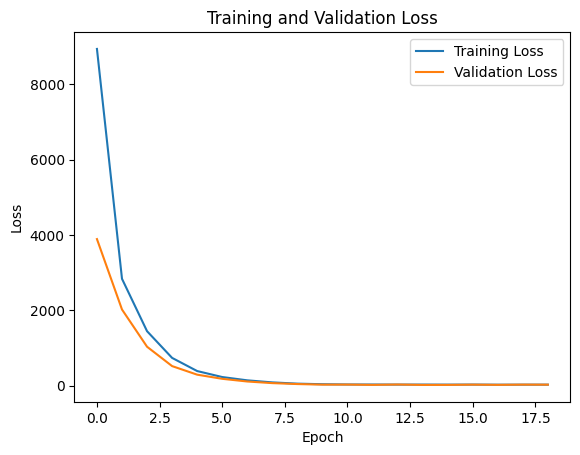

Average Time per Epoch: 5.80s
Average CPU Usage: 17.79%
Average Memory Usage: 4.75GB
Average GPU Usage: 0.36GB
Average GPU Utilization: 7.42%

Total Training Time: 110.25s
Max CPU Usage: 24.80%
Max Memory Usage: 4.75GB
Max GPU Usage: 0.36GB
Max GPU Utilization: 8.00%
MAE:  0.037437033
Average Frobenius distance: 1.6959419
Average MAE node strength: 0.7462354218607752
Average MAE clustering coefficient: 0.1722937161491011
Average MAE betweenness centrality: 0.24352634101769055
Average MAE eigenvector centrality: 0.02379406164055045
Fold 1 Results:
   MAE: 0.03743703290820122
   Average Frobenius distance: 1.6959419250488281
   Average MAE node strength: 0.7462354218607752
   Average MAE clustering coefficient: 0.1722937161491011
   Average MAE betweenness centrality: 0.24352634101769055
   Average MAE eigenvector centrality: 0.02379406164055045

Fold 2/3
Epoch 1:
  Training -> Loss: 8777.597256019468, Generative Loss: 1.3233640269666422, Topological Loss: 877.6273844984711
  Validation 

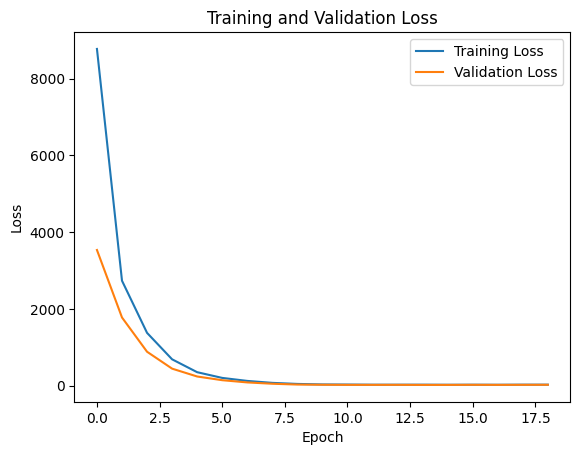

Average Time per Epoch: 5.90s
Average CPU Usage: 16.14%
Average Memory Usage: 4.76GB
Average GPU Usage: 0.36GB
Average GPU Utilization: 7.13%

Total Training Time: 112.12s
Max CPU Usage: 22.45%
Max Memory Usage: 4.76GB
Max GPU Usage: 0.36GB
Max GPU Utilization: 8.00%
MAE:  0.03805572
Average Frobenius distance: 1.747391
Average MAE node strength: 0.6916741156118968
Average MAE clustering coefficient: 0.16052996722449278
Average MAE betweenness centrality: 0.2277646595828414
Average MAE eigenvector centrality: 0.024697582145421403
Fold 2 Results:
   MAE: 0.038055721670389175
   Average Frobenius distance: 1.7473909854888916
   Average MAE node strength: 0.6916741156118968
   Average MAE clustering coefficient: 0.16052996722449278
   Average MAE betweenness centrality: 0.2277646595828414
   Average MAE eigenvector centrality: 0.024697582145421403

Fold 3/3
Epoch 1:
  Training -> Loss: 8398.024028840613, Generative Loss: 1.3015719898900047, Topological Loss: 839.672245588459
  Validation 

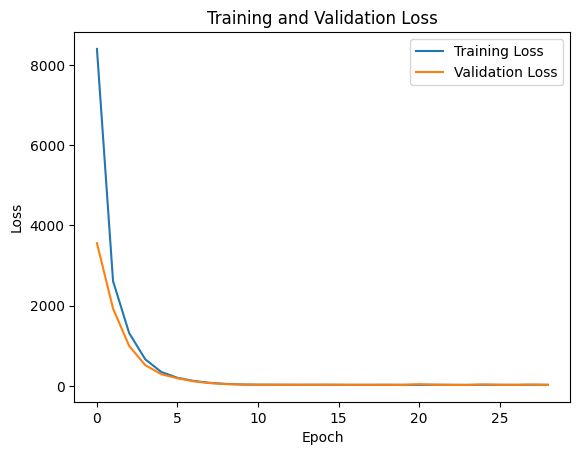

Average Time per Epoch: 5.99s
Average CPU Usage: 20.66%
Average Memory Usage: 4.77GB
Average GPU Usage: 0.36GB
Average GPU Utilization: 7.41%

Total Training Time: 173.75s
Max CPU Usage: 30.80%
Max Memory Usage: 4.77GB
Max GPU Usage: 0.36GB
Max GPU Utilization: 8.00%
MAE:  0.03830367
Average Frobenius distance: 1.7546961
Average MAE node strength: 0.6370006981105586
Average MAE clustering coefficient: 0.19276778216937343
Average MAE betweenness centrality: 0.24815033451397084
Average MAE eigenvector centrality: 0.024499577892372903
Fold 3 Results:
   MAE: 0.038303669542074203
   Average Frobenius distance: 1.7546961307525635
   Average MAE node strength: 0.6370006981105586
   Average MAE clustering coefficient: 0.19276778216937343
   Average MAE betweenness centrality: 0.24815033451397084
   Average MAE eigenvector centrality: 0.024499577892372903

Cross-Validation Results:
mae: Mean = 0.0379, Std = 0.0004
frobenius_distance: Mean = 1.7327, Std = 0.0261
mae_ns: Mean = 0.6916, Std = 0.0

In [25]:
conv_size = simulated_adj_train.shape[2]
hidden_size = conv_size*conv_size
rbgm_simulated_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_simulated_model_1)
print(f"Total number of trainable parameters: {(rbgm_simulated_model_1.count_parameters())*2}\n")

# Train model 
set_seed(42)
avg_metrics, std_metrics = train_test_cv_rbgm(rbgm_simulated_model_1, rbgm_simulated_model_2, simulated_features, simulated_adj,
            num_epochs=100, lr=0.001, step_size=50, gamma=0.1,
            save_path="models/rbgm_simulated")

#### Simple Train-Test

RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  ))
)
RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RN

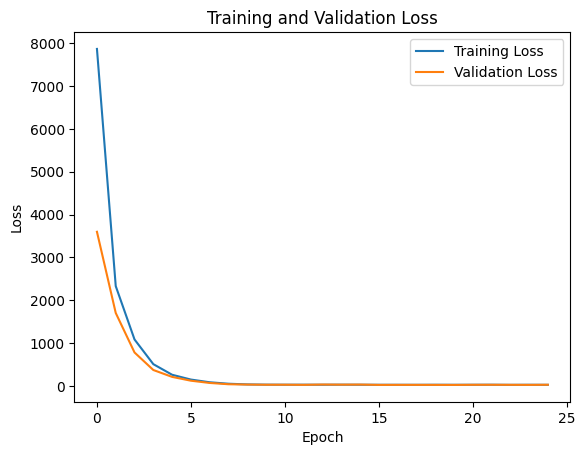

Average Time per Epoch: 13.81s
Average CPU Usage: 27.54%
Average Memory Usage: 3.36GB
Average GPU Usage: 0.19GB
Average GPU Utilization: 4.86%

Total Training Time: 345.27s
Max CPU Usage: 31.75%
Max Memory Usage: 3.36GB
Max GPU Usage: 0.19GB
Max GPU Utilization: 6.00%


In [38]:
conv_size = simulated_adj_train.shape[2]
hidden_size = conv_size*conv_size
rbgm_simulated_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_simulated_model_1)
print(f"Total number of trainable parameters: {(rbgm_simulated_model_1.count_parameters())*2}\n")

# Train model 
set_seed(42)
train_rbgm(rbgm_simulated_model_1, rbgm_simulated_model_2, simulated_adj_train.to(device), simulated_adj_val.to(device),
            num_epochs=100, lr=0.001, step_size=50, gamma=0.1,
            save_path="models/rbgm_simulated")

Mean Squared Error between predicted (t1) and ground truth graphs (t0):  0.0020957692


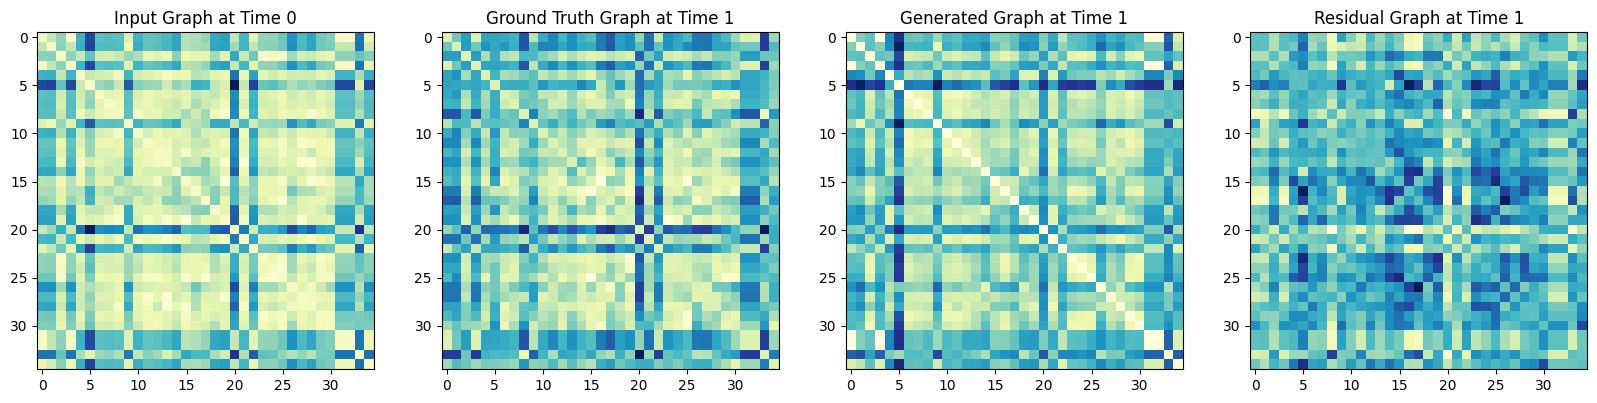

Mean Squared Error between predicted (t2) and ground truth graphs (t1):  0.0032343848


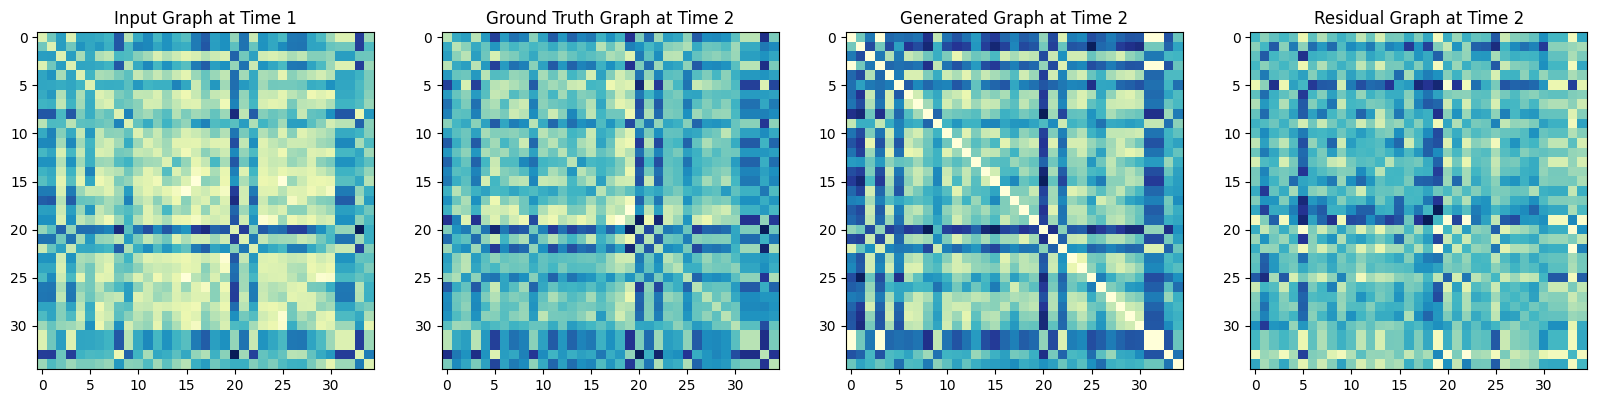

Mean Squared Error between ground truth graphs:  0.0036118329


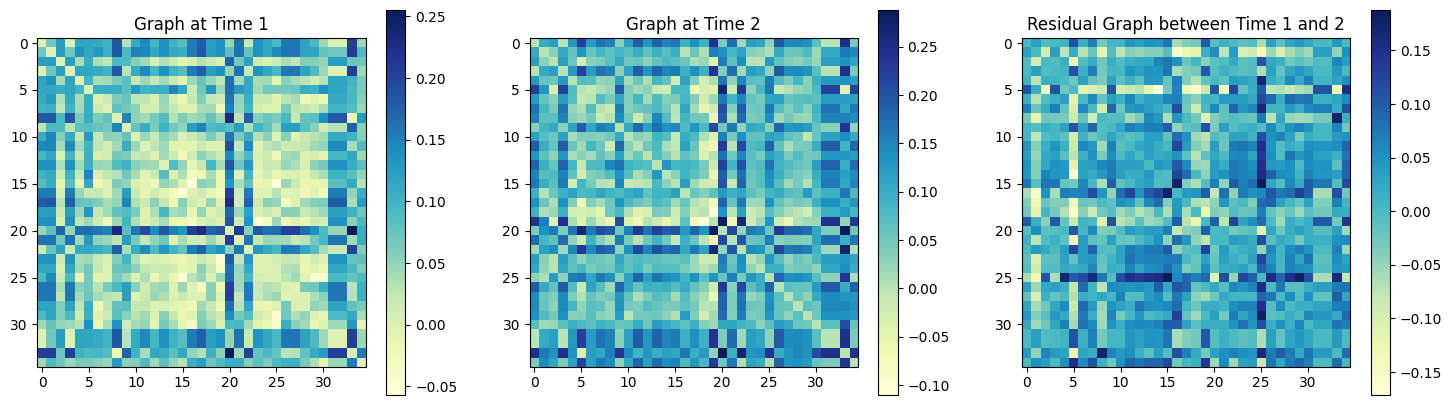

Mean Squared Error between generated graphs:  0.0006054311


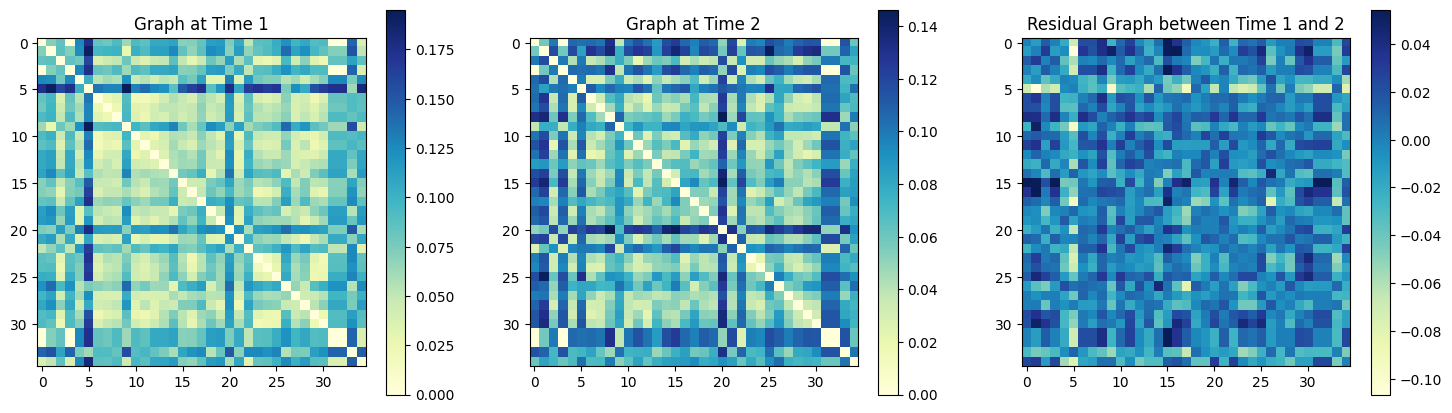

MAE:  0.039167803
Average Frobenius distance: 1.8171238
Average Jaccard distance: 0.06239495798319328
Average MAE global efficiency: 0.0
Average MAE local efficiency: 0.0
Average MAE betweenness centrality: 0.24561306340718106
Average MAE eigenvector centrality: 0.02547474436757601


In [39]:
inference_rbgm(rbgm_simulated_model_1, rbgm_simulated_model_1, simulated_adj_test.to(device), sample_idx=0)
evaluate_rbgm(rbgm_simulated_model_1, rbgm_simulated_model_1, simulated_adj_test.to(device))

## OASIS-2

#### 3-Fold CV

RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  ))
)
Total number of trainable parameters: 6014820


Fold 1/3
Epoch 1:
  Training -> Loss: 279964.23445814935, Generative Loss: 1.8230572005976802, Topological Loss: 27996.240649071293
  Validation -> Loss: 5055.5225, Generative Loss: 1.0783, Topological Loss: 505.4444
Time: 6.81s, CPU: 18.25%, Memory: 4.72GB, GPU: 0.28GB, GPU Util: 4.50%

Epoch 2:
  Training -> Loss: 2

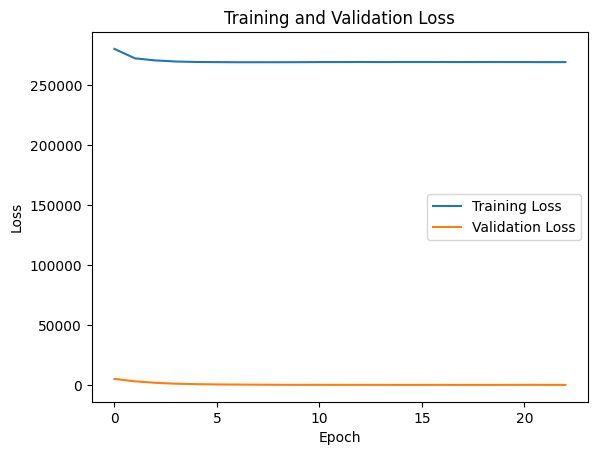

Average Time per Epoch: 6.71s
Average CPU Usage: 17.73%
Average Memory Usage: 4.72GB
Average GPU Usage: 0.29GB
Average GPU Utilization: 7.41%

Total Training Time: 154.36s
Max CPU Usage: 24.55%
Max Memory Usage: 4.72GB
Max GPU Usage: 0.29GB
Max GPU Utilization: 8.00%
MAE:  0.06377697
Average Frobenius distance: 3.0723245
Average MAE node strength: 1.4064312482592312
Average MAE clustering coefficient: 0.13958478382330222
Average MAE betweenness centrality: 0.08183744290294087
Average MAE eigenvector centrality: 0.02467379650488931
Fold 1 Results:
   MAE: 0.06377696990966797
   Average Frobenius distance: 3.072324514389038
   Average MAE node strength: 1.4064312482592312
   Average MAE clustering coefficient: 0.13958478382330222
   Average MAE betweenness centrality: 0.08183744290294087
   Average MAE eigenvector centrality: 0.02467379650488931

Fold 2/3
Epoch 1:
  Training -> Loss: 283302.88343523553, Generative Loss: 1.9467023658579674, Topological Loss: 28330.092517023502
  Validatio

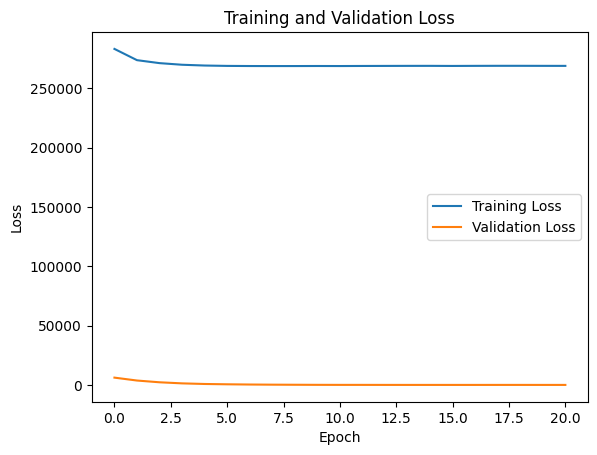

Average Time per Epoch: 6.75s
Average CPU Usage: 19.04%
Average Memory Usage: 4.72GB
Average GPU Usage: 0.29GB
Average GPU Utilization: 7.31%

Total Training Time: 141.68s
Max CPU Usage: 26.15%
Max Memory Usage: 4.72GB
Max GPU Usage: 0.29GB
Max GPU Utilization: 8.00%
MAE:  0.051532924
Average Frobenius distance: 2.3399591
Average MAE node strength: 1.0689959823411825
Average MAE clustering coefficient: 0.1409112801950801
Average MAE betweenness centrality: 0.08312311727085117
Average MAE eigenvector centrality: 0.02327567565210775
Fold 2 Results:
   MAE: 0.05153292417526245
   Average Frobenius distance: 2.339959144592285
   Average MAE node strength: 1.0689959823411825
   Average MAE clustering coefficient: 0.1409112801950801
   Average MAE betweenness centrality: 0.08312311727085117
   Average MAE eigenvector centrality: 0.02327567565210775

Fold 3/3
Epoch 1:
  Training -> Loss: 15380.939381032751, Generative Loss: 1.6405942394681599, Topological Loss: 1537.9298835422683
  Validation

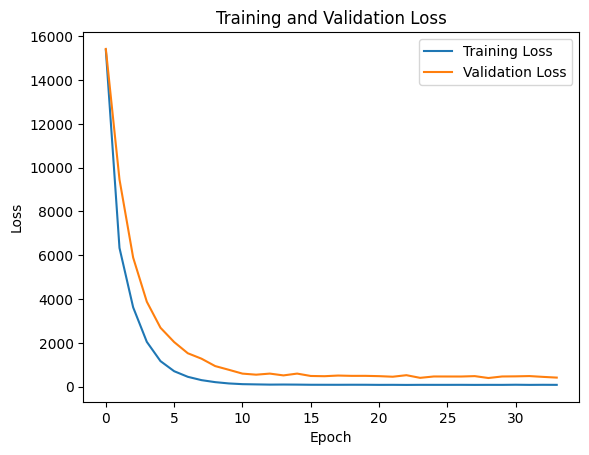

Average Time per Epoch: 6.73s
Average CPU Usage: 19.24%
Average Memory Usage: 4.73GB
Average GPU Usage: 0.29GB
Average GPU Utilization: 7.50%

Total Training Time: 228.82s
Max CPU Usage: 27.45%
Max Memory Usage: 4.73GB
Max GPU Usage: 0.29GB
Max GPU Utilization: 8.00%
MAE:  0.17354426
Average Frobenius distance: 20.147131
Average MAE node strength: 5.168384971537176
Average MAE clustering coefficient: 0.15320615214697053
Average MAE betweenness centrality: 0.08309857642398553
Average MAE eigenvector centrality: 0.023582680639164647
Fold 3 Results:
   MAE: 0.1735442578792572
   Average Frobenius distance: 20.147130966186523
   Average MAE node strength: 5.168384971537176
   Average MAE clustering coefficient: 0.15320615214697053
   Average MAE betweenness centrality: 0.08309857642398553
   Average MAE eigenvector centrality: 0.023582680639164647

Cross-Validation Results:
mae: Mean = 0.0963, Std = 0.0549
frobenius_distance: Mean = 8.5198, Std = 8.2272
mae_ns: Mean = 2.5479, Std = 1.8581


In [23]:
conv_size = oasis_adj_train.shape[2]
hidden_size = conv_size*conv_size
rbgm_oasis_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_oasis_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_oasis_model_1)
print(f"Total number of trainable parameters: {(rbgm_oasis_model_1.count_parameters())*2}\n")

avg_metrics, std_metrics = train_test_cv_rbgm(rbgm_oasis_model_1, rbgm_oasis_model_2, oasis_features, oasis_adj, 
                        num_folds=3, lr=0.001, num_epochs=200, step_size=50, gamma=0.1, 
                        save_path="models/rbgm_oasis")

#### Simple Train-Test

RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  ))
)
Total number of trainable parameters: 6014820

Epoch 1:
  Training -> Loss: 244893.70902686784, Generative Loss: 1.7531930823114854, Topological Loss: 24489.19491746154
  Validation -> Loss: 6488.0360, Generative Loss: 1.1566, Topological Loss: 648.6879
Time: 15.30s, CPU: 20.55%, Memory: 3.34GB, GPU: 0.41GB, GPU Util: 4.00%

Epoch 2:
  Training -> Loss: 237727.6516

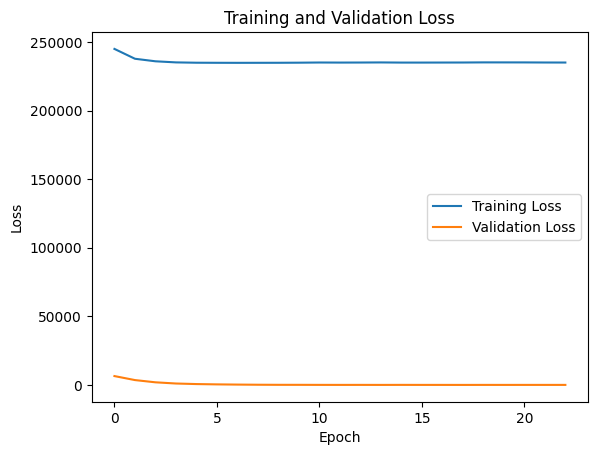

Average Time per Epoch: 15.32s
Average CPU Usage: 26.76%
Average Memory Usage: 3.35GB
Average GPU Usage: 0.43GB
Average GPU Utilization: 5.33%

Total Training Time: 352.39s
Max CPU Usage: 32.55%
Max Memory Usage: 3.36GB
Max GPU Usage: 0.43GB
Max GPU Utilization: 6.00%


In [36]:
conv_size = oasis_adj_train.shape[2]
hidden_size = conv_size*conv_size
rbgm_oasis_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_oasis_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_oasis_model_1)
print(f"Total number of trainable parameters: {(rbgm_oasis_model_1.count_parameters())*2}\n")

# Train model 
set_seed(42)
train_rbgm(rbgm_oasis_model_1, rbgm_oasis_model_2, oasis_adj_train.to(device), oasis_adj_val.to(device),
            num_epochs=100, lr=0.001, step_size=50, gamma=0.1,
            save_path="models/rbgm_oasis")

Mean Squared Error between predicted (t1) and ground truth graphs (t0):  0.0028417108


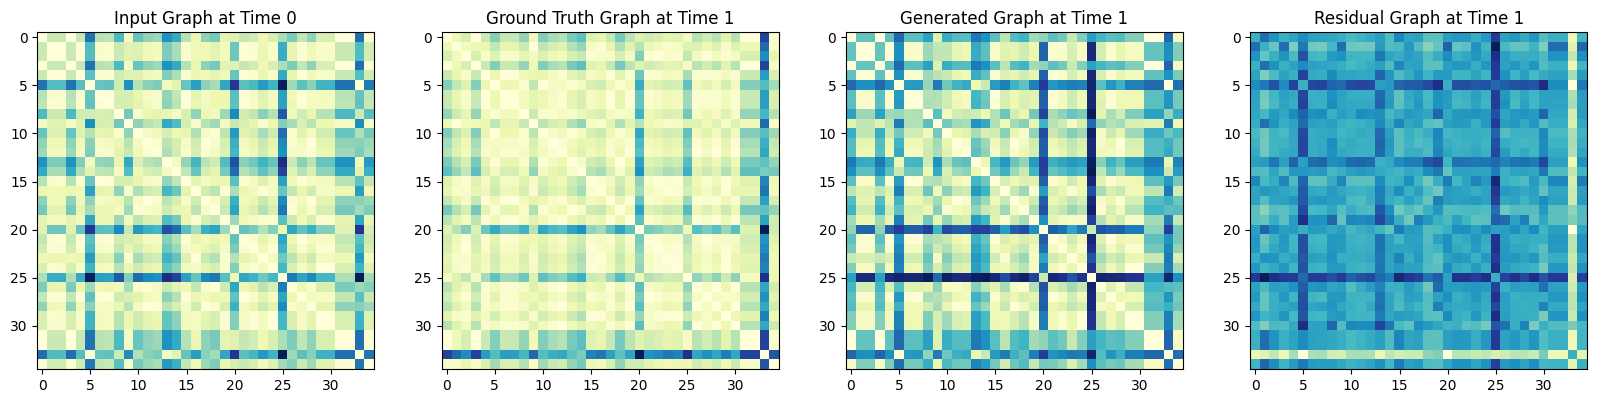

Mean Squared Error between predicted (t2) and ground truth graphs (t1):  0.005193771


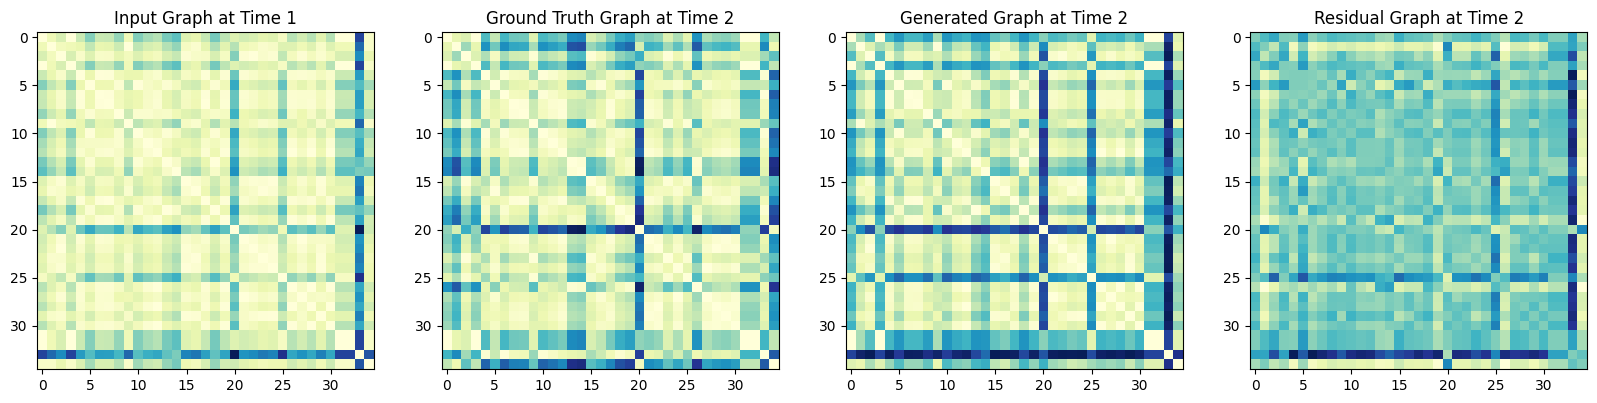

Mean Squared Error between ground truth graphs:  0.0046917056


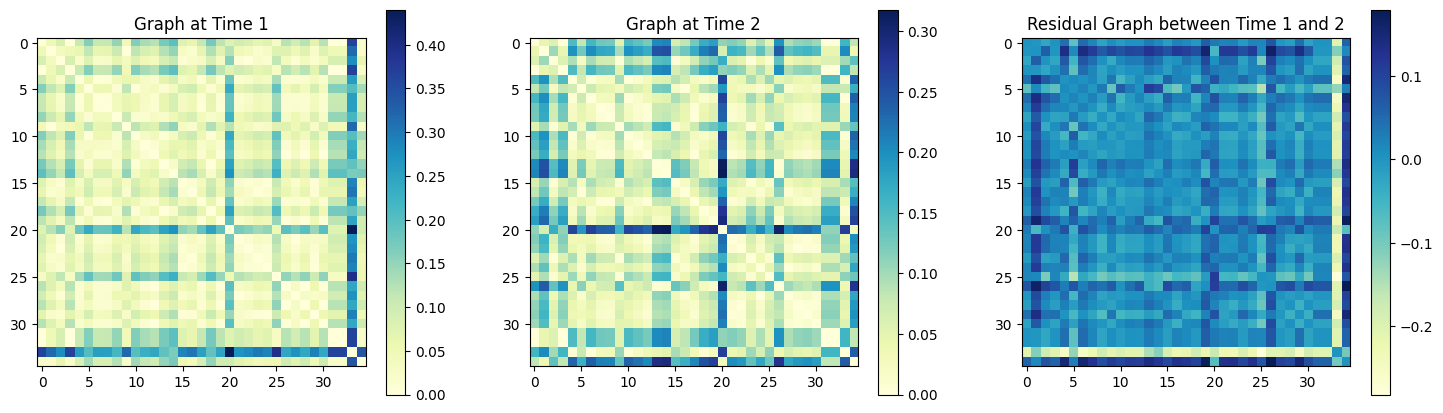

Mean Squared Error between generated graphs:  0.002235467


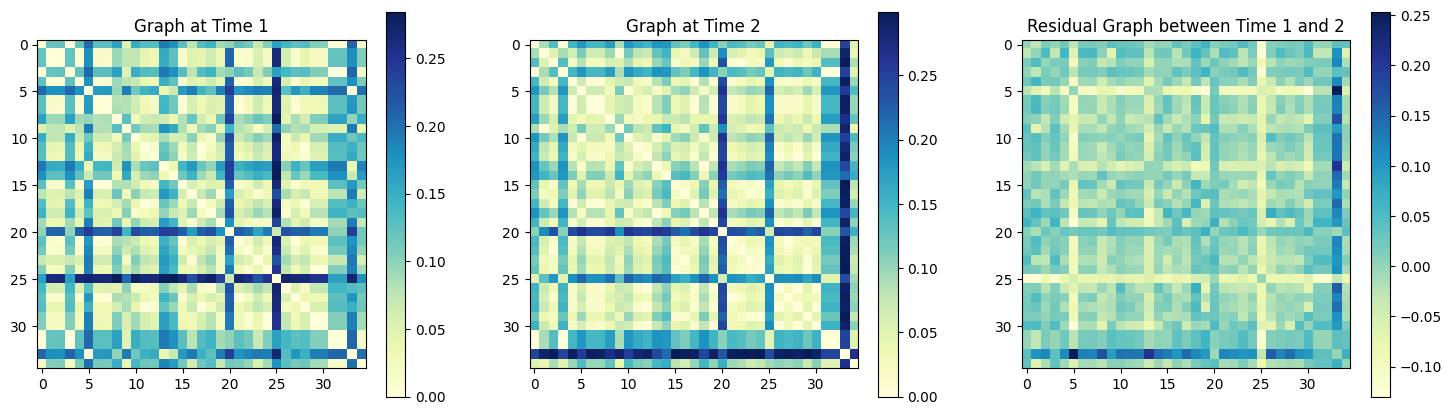

MAE:  0.059270967
Average Frobenius distance: 2.8222268
Average Jaccard distance: 0.010084033613445342
Average MAE global efficiency: 0.005042016806722671
Average MAE local efficiency: 0.004736440030557398
Average MAE betweenness centrality: 0.0836863454589295
Average MAE eigenvector centrality: 0.024366749173743974


In [37]:
inference_rbgm(rbgm_oasis_model_1, rbgm_oasis_model_1, oasis_adj_test.to(device), sample_idx=0)
evaluate_rbgm(rbgm_oasis_model_1, rbgm_oasis_model_1, oasis_adj_test.to(device))

## EMCI-AD

#### 3-Fold CV

RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  ))
)
Total number of trainable parameters: 6014820


Fold 1/3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1:
  Training -> Loss: 601538.5859375, Generative Loss: 5.020332503318786, Topological Loss: 60153.356640625
  Validation -> Loss: 109438.6738, Generative Loss: 2.8163, Topological Loss: 10943.5857
Time: 1.33s, CPU: 10.70%, Memory: 4.73GB, GPU: 0.30GB, GPU Util: 4.50%

Epoch 2:
  Training -> Loss: 86368.41669921875, Generative Loss: 2.494991597533226, Topological Loss: 8636.592205810546
  Validation -> Loss: 49606.1079, Generative Loss: 1.8443, Topological Loss: 4960.4265
Time: 1.33s, CPU: 27.45%, Memory: 4.74GB, GPU: 0.31GB, GPU Util: 7.50%

Epoch 3:
  Training -> Loss: 47861.025634765625, Generative Loss: 1.8593490809202193, Topological Loss: 4785.916668701172
  Validation -> Loss: 35379.3071, Generative Loss: 1.5850, Topological Loss: 3537.7723
Time: 1.32s, CPU: 32.40%, Memory: 4.74GB, GPU: 0.31GB, GPU Util: 8.50%

Epoch 4:
  Training -> Loss: 34816.36357421875, Generative Loss: 1.5889390632510185, Topological Loss: 3481.477459716797
  Validation -> Loss: 27528.5210, Generativ

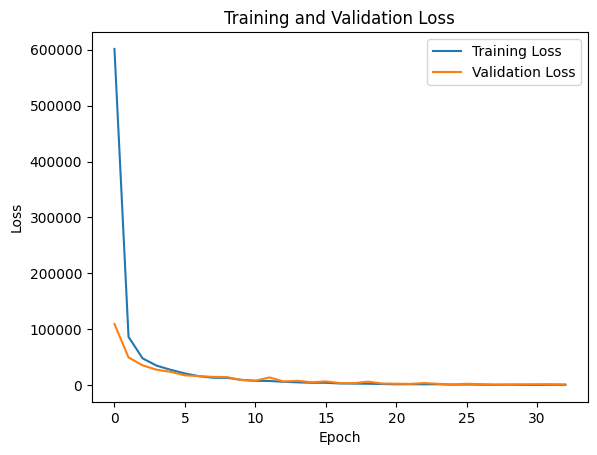

Average Time per Epoch: 1.30s
Average CPU Usage: 16.27%
Average Memory Usage: 4.74GB
Average GPU Usage: 0.31GB
Average GPU Utilization: 8.68%

Total Training Time: 42.83s
Max CPU Usage: 32.40%
Max Memory Usage: 4.74GB
Max GPU Usage: 0.31GB
Max GPU Utilization: 10.00%
MAE:  0.38132015
Average Frobenius distance: 15.668567
Average MAE node strength: 12.31345819986261
Average MAE clustering coefficient: 0.10621993750187463
Average MAE betweenness centrality: 0.0966681753266688
Average MAE eigenvector centrality: 0.012852422999780636
Fold 1 Results:
   MAE: 0.38132014870643616
   Average Frobenius distance: 15.668566703796387
   Average MAE node strength: 12.31345819986261
   Average MAE clustering coefficient: 0.10621993750187463
   Average MAE betweenness centrality: 0.0966681753266688
   Average MAE eigenvector centrality: 0.012852422999780636

Fold 2/3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1:
  Training -> Loss: 618146.0952743902, Generative Loss: 4.842788649768364, Topological Loss: 61814.125917016005
  Validation -> Loss: 121251.8340, Generative Loss: 2.9457, Topological Loss: 12124.8887
Time: 1.36s, CPU: 19.60%, Memory: 4.75GB, GPU: 0.30GB, GPU Util: 4.50%

Epoch 2:
  Training -> Loss: 83412.13009717988, Generative Loss: 2.470793136736242, Topological Loss: 8340.965945360138
  Validation -> Loss: 81760.6504, Generative Loss: 2.3879, Topological Loss: 8175.8263
Time: 1.33s, CPU: 13.55%, Memory: 4.75GB, GPU: 0.31GB, GPU Util: 9.00%

Epoch 3:
  Training -> Loss: 45103.00154820884, Generative Loss: 1.7963471645262183, Topological Loss: 4510.120444693216
  Validation -> Loss: 53152.3599, Generative Loss: 1.8417, Topological Loss: 5315.0518
Time: 1.33s, CPU: 16.65%, Memory: 4.75GB, GPU: 0.31GB, GPU Util: 8.00%

Epoch 4:
  Training -> Loss: 35243.381026105184, Generative Loss: 1.597510006369614, Topological Loss: 3524.1783238852895
  Validation -> Loss: 39890.8740, Gen

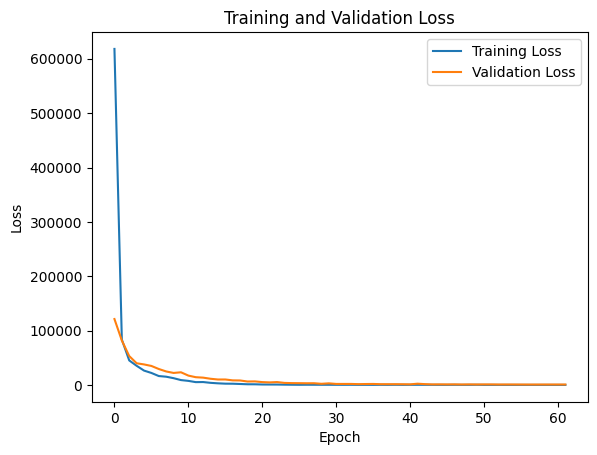

Average Time per Epoch: 1.33s
Average CPU Usage: 17.60%
Average Memory Usage: 4.75GB
Average GPU Usage: 0.31GB
Average GPU Utilization: 8.68%

Total Training Time: 82.65s
Max CPU Usage: 30.20%
Max Memory Usage: 4.75GB
Max GPU Usage: 0.31GB
Max GPU Utilization: 9.50%
MAE:  0.18636936
Average Frobenius distance: 8.093566
Average MAE node strength: 5.011262489865495
Average MAE clustering coefficient: 0.06265720785364355
Average MAE betweenness centrality: 0.09088372539098283
Average MAE eigenvector centrality: 0.008654851527070946
Fold 2 Results:
   MAE: 0.18636935949325562
   Average Frobenius distance: 8.093565940856934
   Average MAE node strength: 5.011262489865495
   Average MAE clustering coefficient: 0.06265720785364355
   Average MAE betweenness centrality: 0.09088372539098283
   Average MAE eigenvector centrality: 0.008654851527070946

Fold 3/3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1:
  Training -> Loss: 618141.1850228659, Generative Loss: 5.1799168470429215, Topological Loss: 61813.60170541159
  Validation -> Loss: 144452.7344, Generative Loss: 3.2004, Topological Loss: 14444.9534
Time: 1.36s, CPU: 25.95%, Memory: 4.75GB, GPU: 0.30GB, GPU Util: 4.50%

Epoch 2:
  Training -> Loss: 93175.3720464939, Generative Loss: 2.6010706366562264, Topological Loss: 9317.277022198932
  Validation -> Loss: 74873.9395, Generative Loss: 2.2923, Topological Loss: 7487.1649
Time: 1.37s, CPU: 24.90%, Memory: 4.75GB, GPU: 0.31GB, GPU Util: 9.00%

Epoch 3:
  Training -> Loss: 53078.842606707316, Generative Loss: 1.9663184910285763, Topological Loss: 5307.687636956936
  Validation -> Loss: 49145.6084, Generative Loss: 1.7880, Topological Loss: 4914.3819
Time: 1.36s, CPU: 14.10%, Memory: 4.75GB, GPU: 0.31GB, GPU Util: 8.50%

Epoch 4:
  Training -> Loss: 40250.56454839939, Generative Loss: 1.708499905539722, Topological Loss: 4024.8856201171875
  Validation -> Loss: 41525.2341, Gen

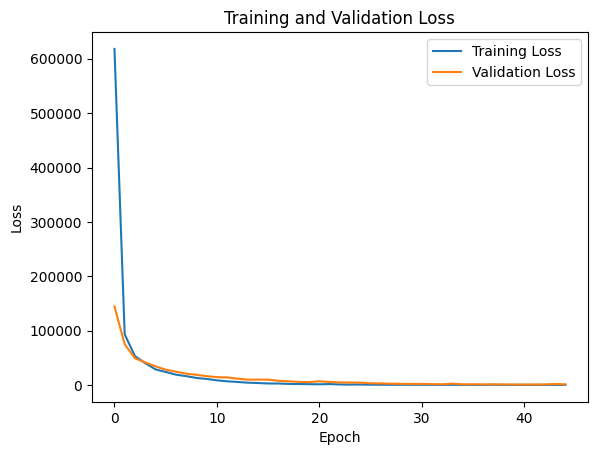

Average Time per Epoch: 1.33s
Average CPU Usage: 18.49%
Average Memory Usage: 4.75GB
Average GPU Usage: 0.31GB
Average GPU Utilization: 8.74%

Total Training Time: 59.90s
Max CPU Usage: 30.05%
Max Memory Usage: 4.75GB
Max GPU Usage: 0.31GB
Max GPU Utilization: 10.00%
MAE:  0.20418124
Average Frobenius distance: 9.60249
Average MAE node strength: 4.775150657968018
Average MAE clustering coefficient: 0.05917254089341322
Average MAE betweenness centrality: 0.08695322206017395
Average MAE eigenvector centrality: 0.008777666550886404
Fold 3 Results:
   MAE: 0.2041812390089035
   Average Frobenius distance: 9.602490425109863
   Average MAE node strength: 4.775150657968018
   Average MAE clustering coefficient: 0.05917254089341322
   Average MAE betweenness centrality: 0.08695322206017395
   Average MAE eigenvector centrality: 0.008777666550886404

Cross-Validation Results:
mae: Mean = 0.2573, Std = 0.0880
frobenius_distance: Mean = 11.1215, Std = 3.2737
mae_ns: Mean = 7.3666, Std = 3.4993
ma

In [24]:
conv_size = emci_adj_train.shape[2]
hidden_size = conv_size*conv_size
rbgm_emci_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_emci_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_emci_model_1)
print(f"Total number of trainable parameters: {(rbgm_emci_model_1.count_parameters())*2}\n")

# Train model 
set_seed(42)
avg_metrics, std_metrics = train_test_cv_rbgm(rbgm_emci_model_1, rbgm_emci_model_2, emci_features, emci_adj,
            num_epochs=100, lr=0.001, step_size=50, gamma=0.1,
            save_path="models/rbgm_emci")

#### Simple Train-Test

RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  ))
)
RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RN

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1:
  Training -> Loss: 639238.0716711957, Generative Loss: 5.024361340895943, Topological Loss: 63923.306024966034
  Validation -> Loss: 124428.6719, Generative Loss: 3.0616, Topological Loss: 12442.5610
Time: 2.83s, CPU: 18.50%, Memory: 3.36GB, GPU: 0.21GB, GPU Util: 3.50%

Epoch 2:
  Training -> Loss: 90826.11790930707, Generative Loss: 2.5519055853719297, Topological Loss: 9082.356519616169
  Validation -> Loss: 56081.3105, Generative Loss: 1.9908, Topological Loss: 5607.9319
Time: 2.89s, CPU: 21.80%, Memory: 3.36GB, GPU: 0.22GB, GPU Util: 6.00%

Epoch 3:
  Training -> Loss: 51335.33237092391, Generative Loss: 1.9341455361117488, Topological Loss: 5133.339769446332
  Validation -> Loss: 43353.2689, Generative Loss: 1.7662, Topological Loss: 4335.1502
Time: 2.59s, CPU: 13.45%, Memory: 3.36GB, GPU: 0.22GB, GPU Util: 6.00%

Epoch 4:
  Training -> Loss: 36994.66983695652, Generative Loss: 1.6231724840143453, Topological Loss: 3699.3046875
  Validation -> Loss: 31800.8337, Generati

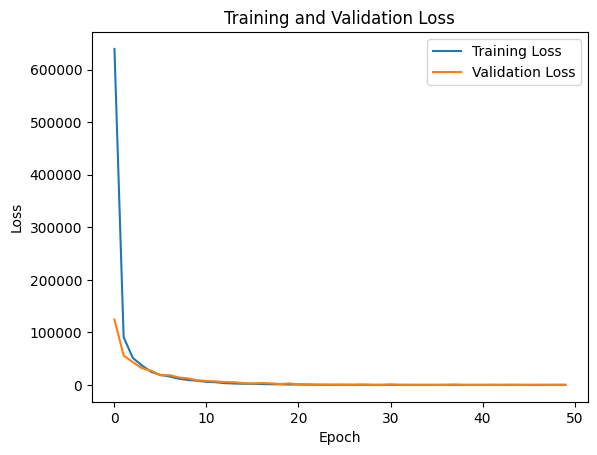

Average Time per Epoch: 2.80s
Average CPU Usage: 23.21%
Average Memory Usage: 3.36GB
Average GPU Usage: 0.22GB
Average GPU Utilization: 5.45%

Total Training Time: 140.08s
Max CPU Usage: 33.35%
Max Memory Usage: 3.36GB
Max GPU Usage: 0.22GB
Max GPU Utilization: 6.50%


In [40]:
conv_size = emci_adj_train.shape[2]
hidden_size = conv_size*conv_size
rbgm_emci_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_emci_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_emci_model_1)
print(f"Total number of trainable parameters: {(rbgm_emci_model_1.count_parameters())*2}\n")

# Train model 
set_seed(42)
train_rbgm(rbgm_emci_model_1, rbgm_emci_model_2, emci_adj_train.to(device), emci_adj_val.to(device),
            num_epochs=100, lr=0.001, step_size=50, gamma=0.1,
            save_path="models/rbgm_emci")

Mean Squared Error between predicted (t1) and ground truth graphs (t0):  0.031679045


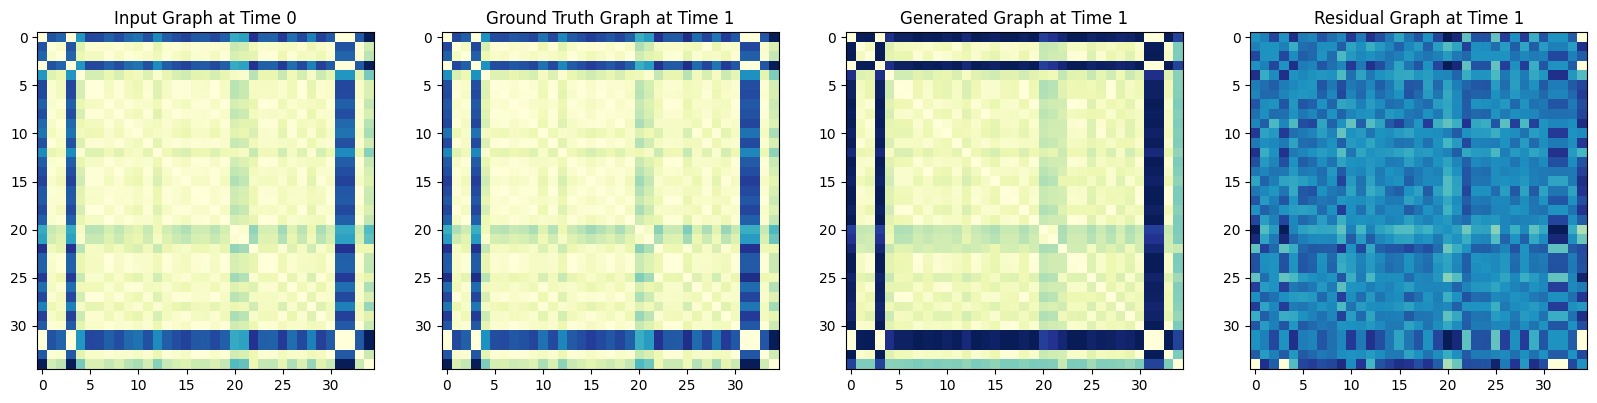

MAE:  0.17535834
Average Frobenius distance: 8.1678095
Average Jaccard distance: 0.010084033613445342
Average MAE global efficiency: 0.005042016806722671
Average MAE local efficiency: 0.004736440030557398
Average MAE betweenness centrality: 0.09567776201389645
Average MAE eigenvector centrality: 0.008469447495371601


In [76]:
inference_rbgm(rbgm_emci_model_1, rbgm_emci_model_1, emci_adj_test.to(device), sample_idx=1)
evaluate_rbgm(rbgm_emci_model_1, rbgm_emci_model_1, emci_adj_test.to(device))

## SLIM160

#### Simple Train-Test

In [78]:
conv_size = slim160_adj_train.shape[2]
hidden_size = conv_size*conv_size
rbgm_slim160_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_slim160_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_slim160_model_1)
print(rbgm_slim160_model_2)
print(f"Total number of trainable parameters: {(rbgm_slim160_model_1.count_parameters())*2}\n")

# Train model 
train_rbgm(rbgm_slim160_model_1, rbgm_slim160_model_2, slim160_adj_train.to(device), slim160_adj_val.to(device),
            num_epochs=100, lr=0.001, step_size=50, gamma=0.1,
            save_path="models/rbgm_slim160")

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.44 GiB. GPU 0 has a total capacty of 15.89 GiB of which 398.69 MiB is free. Process 1232900 has 15.50 GiB memory in use. Of the allocated memory 14.82 GiB is allocated by PyTorch, and 78.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
inference_rbgm(rbgm_slim160_model_1, rbgm_slim160_model_1, slim160_adj_test.to(device), sample_idx=1)
evaluate_rbgm(rbgm_slim160_model_1, rbgm_slim160_model_1, slim160_adj_test.to(device))

# EvoGraph

In [5]:
class EvoGenerator(nn.Module):
    def __init__(self, conv_size, hidden_size):
        super(EvoGenerator, self).__init__()
        self.conv_size = conv_size
        self.hidden_size = hidden_size

        lin = Sequential(Linear(1, self.hidden_size), ReLU())
        self.conv1 = NNConv(self.conv_size, self.conv_size, lin, aggr='mean', root_weight=True, bias=True)
        self.conv11 = BatchNorm(self.conv_size, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

        lin = Sequential(Linear(1, self.conv_size), ReLU())
        self.conv2 = NNConv(self.conv_size, 1, lin, aggr='mean', root_weight=True, bias=True)
        self.conv22 = BatchNorm(1, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

        lin = Sequential(Linear(1, self.conv_size), ReLU())
        self.conv3 = NNConv(1, self.conv_size, lin, aggr='mean', root_weight=True, bias=True)
        self.conv33 = BatchNorm(self.conv_size, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x1 = torch.sigmoid(self.conv11(self.conv1(x, edge_index, edge_attr)))
        x1 = F.dropout(x1, training=self.training)
        
        x1 = (x1 + x1.T) / 2.0
        x1.fill_diagonal_(fill_value=0)
        x2 = torch.sigmoid(self.conv22(self.conv2(x1, edge_index, edge_attr)))
        x2 = F.dropout(x2, training=self.training)

        x3 = torch.cat([torch.sigmoid(self.conv33(self.conv3(x2, edge_index, edge_attr))), x1], dim=1)
        x4 = x3[:, 0:self.conv_size]
        x5 = x3[:, self.conv_size:self.conv_size*2]

        x6 = (x4 + x5) / 2
        x6 = (x6 + x6.T) / 2.0
        x6.fill_diagonal_(fill_value=0)
        return x6
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class EvoDiscriminator(nn.Module):
    def __init__(self, conv_size, hidden_size):
        super(EvoDiscriminator, self).__init__()
        self.conv_size = conv_size
        self.hidden_size = hidden_size
        
        lin = Sequential(Linear(2, self.hidden_size), ReLU())
        self.conv1 = NNConv(self.conv_size, self.conv_size, lin, aggr='mean', root_weight=True, bias=True)
        self.conv11 = BatchNorm(self.conv_size, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

        lin = Sequential(Linear(2, self.conv_size), ReLU())
        self.conv2 = NNConv(self.conv_size, 1, lin, aggr='mean', root_weight=True, bias=True)
        self.conv22 = BatchNorm(1, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

    def forward(self, data, data_to_translate):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        edge_attr_data_to_translate = data_to_translate.edge_attr

        edge_attr_data_to_translate_reshaped = edge_attr_data_to_translate.view(self.hidden_size, 1)

        gen_input = torch.cat((edge_attr, edge_attr_data_to_translate_reshaped), -1)
        x = F.relu(self.conv11(self.conv1(x, edge_index, gen_input)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv22(self.conv2(x, edge_index, gen_input)))

        return torch.sigmoid(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


def train_evograph(generator_1, discriminator_1, generator_2, discriminator_2, train_adj, val_adj,
                   num_epochs=500, lr_g=0.01, lr_d=0.0002, save_path='models/EvoGraph/evograph_model',
                   tp_c=0.00, g_c=2.0, i_c=2.0, kl_c=0.001, patience=5, gradient_clip=1.0, step_size=50, gamma=0.1):

    adversarial_loss = torch.nn.BCELoss().to(device)
    identity_loss = torch.nn.L1Loss().to(device)
    msel = torch.nn.MSELoss().to(device)
    mael = torch.nn.L1Loss().to(device)
    tp = torch.nn.MSELoss().to(device)

    optimizer_G1 = torch.optim.AdamW(generator_1.parameters(), lr=lr_g, betas=(0.5, 0.999), weight_decay=0.0)
    optimizer_D1 = torch.optim.AdamW(discriminator_1.parameters(), lr=lr_d, betas=(0.5, 0.999), weight_decay=0.0)
    optimizer_G2 = torch.optim.AdamW(generator_2.parameters(), lr=lr_g, betas=(0.5, 0.999), weight_decay=0.0)
    optimizer_D2 = torch.optim.AdamW(discriminator_2.parameters(), lr=lr_d, betas=(0.5, 0.999), weight_decay=0.0)

    scheduler_G1 = torch.optim.lr_scheduler.StepLR(optimizer_G1, step_size=step_size, gamma=gamma)
    scheduler_D1 = torch.optim.lr_scheduler.StepLR(optimizer_D1, step_size=step_size, gamma=gamma)
    scheduler_G2 = torch.optim.lr_scheduler.StepLR(optimizer_G2, step_size=step_size, gamma=gamma)
    scheduler_D2 = torch.optim.lr_scheduler.StepLR(optimizer_D2, step_size=step_size, gamma=gamma)

    num_nodes = train_adj.shape[2]
    real_label = torch.ones(num_nodes, 1).to(device)
    fake_label = torch.zeros(num_nodes, 1).to(device)

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    generator_1.to(device)
    discriminator_1.to(device)
    generator_2.to(device)
    discriminator_2.to(device)
    process = psutil.Process()

    for epoch in range(num_epochs):
        r1, f1, d1, g1, mse_l1, mae_l1 = 0, 0, 0, 0, 0, 0
        r2, f2, d2, g2, mse_l2, mae_l2 = 0, 0, 0, 0, 0, 0

        generator_1.train()
        discriminator_1.train()
        generator_2.train()
        discriminator_2.train()

        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        for i in range(train_adj.size(0)):
            data = train_adj.to(device)
            num_time_points = data[i].size(0)

            edge_idx_t0, edge_att_t0, _, _ = create_edge_index_attribute(data[i, 0])
            data_t0 = Data(x=data[i, 0], edge_attr=edge_att_t0, edge_index=edge_idx_t0).to(device)
            edge_idx_t1, edge_att_t1, _, _ = create_edge_index_attribute(data[i, 1])
            data_t1 = Data(x=data[i, 1], edge_attr=edge_att_t1, edge_index=edge_idx_t1).to(device)

            # 1st Part Training
            optimizer_D1.zero_grad()
            fake_t1 = generator_1(data_t0).detach()
            edge_idx_f1, edge_att_f1, _, _ = create_edge_index_attribute(fake_t1)
            fake_data_t1 = Data(x=fake_t1, edge_attr=edge_att_f1, edge_index=edge_idx_f1).to(device)

            real_loss_1 = adversarial_loss(discriminator_1(data_t1, data_t0), real_label)
            fake_loss_1 = adversarial_loss(discriminator_1(fake_data_t1, data_t0), fake_label)
            loss_D1 = torch.mean(real_loss_1 + fake_loss_1) / 2
            r1 += real_loss_1.item()
            f1 += fake_loss_1.item()
            d1 += loss_D1.item()

            loss_D1.backward()
            optimizer_D1.step()

            optimizer_G1.zero_grad()
            fake_data_t1.x = generator_1(data_t0)
            gan_loss_1 = torch.mean(adversarial_loss(discriminator_1(fake_data_t1, data_t0), real_label))
            kl_loss_1 = kl.kl_divergence(normal.Normal(fake_data_t1.x.mean(dim=1), fake_data_t1.x.std(dim=1)),
                                         normal.Normal(data_t1.x.mean(dim=1), data_t1.x.std(dim=1))).sum()
            tp_loss_1 = tp(fake_data_t1.x.sum(dim=-1), data_t0.x.sum(dim=-1))
            swapped_data = generator_1(data_t1)
            loss_G1 = (i_c * identity_loss(generator_1(data_t1), data_t1.x)) + (g_c * gan_loss_1) + (kl_c * kl_loss_1) + (tp_c * tp_loss_1)
            g1 += loss_G1.item()
            loss_G1.backward()
            nn_utils.clip_grad_norm_(generator_1.parameters(), gradient_clip)
            optimizer_G1.step()

            mse_l1 += msel(generator_1(data_t0), data_t1.x).item()
            mae_l1 += mael(generator_1(data_t0), data_t1.x).item()

            if num_time_points == 3:
                edge_idx_t2, edge_att_t2, _, _ = create_edge_index_attribute(data[i, 2])
                data_t2 = Data(x=data[i, 2], edge_attr=edge_att_t2, edge_index=edge_idx_t2).to(device)

                # 2nd Part Training
                optimizer_D2.zero_grad()
                fake_t2 = generator_2(data_t1).detach()
                edge_idx_f2, edge_att_f2, _, _ = create_edge_index_attribute(fake_t2)
                fake_data_t2 = Data(x=fake_t2, edge_attr=edge_att_f2, edge_index=edge_idx_f2).to(device)

                real_loss_2 = adversarial_loss(discriminator_2(data_t2, data_t1), real_label)
                fake_loss_2 = adversarial_loss(discriminator_2(fake_data_t2, data_t1), fake_label)
                loss_D2 = torch.mean(real_loss_2 + fake_loss_2) / 2
                r2 += real_loss_2.item()
                f2 += fake_loss_2.item()
                d2 += loss_D2.item()

                loss_D2.backward()
                optimizer_D2.step()

                optimizer_G2.zero_grad()
                fake_data_t2.x = generator_2(data_t1)
                gan_loss_2 = torch.mean(adversarial_loss(discriminator_2(fake_data_t2, data_t1), real_label))
                kl_loss_2 = kl.kl_divergence(normal.Normal(fake_data_t2.x.mean(dim=1), fake_data_t2.x.std(dim=1)),
                                             normal.Normal(data_t2.x.mean(dim=1), data_t2.x.std(dim=1))).sum()
                tp_loss_2 = tp(fake_data_t2.x.sum(dim=-1), data_t1.x.sum(dim=-1))
                loss_G2 = (i_c * identity_loss(generator_2(data_t2), data_t2.x)) + (g_c * gan_loss_2) + (kl_c * kl_loss_2) + (tp_c * tp_loss_2)
                g2 += loss_G2.item()
                loss_G2.backward()
                nn_utils.clip_grad_norm_(generator_2.parameters(), gradient_clip)
                optimizer_G2.step()

                mse_l2 += msel(generator_2(data_t0), data_t2.x).item()
                mae_l2 += mael(generator_2(data_t0), data_t2.x).item()

        scheduler_G1.step()
        scheduler_D1.step()
        scheduler_G2.step()
        scheduler_D2.step()

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)

        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        d1 /= train_adj.size(0)
        g1 /= train_adj.size(0)
        d2 /= train_adj.size(0) if num_time_points == 3 else 1
        g2 /= train_adj.size(0) if num_time_points == 3 else 1

        training_loss.append(d1 + g1 + d2 + g2)

        print(f'Epoch {epoch + 1}:\n  Training -> D1 Loss: {d1:.5f}, G1 Loss: {g1:.5f}, D2 Loss: {d2:.5f}, G2 Loss: {g2:.5f}')

        # Validation step
        generator_1.eval()
        discriminator_1.eval()
        generator_2.eval()
        discriminator_2.eval()
        val_loss_1, val_loss_2 = 0.0, 0.0
        val_tp_loss_1, val_tp_loss_2, val_gen_loss_1, val_gen_loss_2 = 0.0, 0.0, 0.0, 0.0

        with torch.no_grad():
            for i in range(val_adj.size(0)):
                data = val_adj[i]
                num_time_points = data.size(0)

                edge_idx_t, edge_att_t, _, _ = create_edge_index_attribute(data[0])
                data_t = Data(x=data[0], edge_attr=edge_att_t, edge_index=edge_idx_t).to(device)
                edge_idx_t_next, edge_att_t_next, _, _ = create_edge_index_attribute(data[1])
                data_t_next = Data(x=data[1], edge_attr=edge_att_t_next, edge_index=edge_idx_t_next).to(device)

                out_1 = generator_1(data_t)
                tpl_1 = tp(out_1.sum(dim=-1), data_t_next.x.sum(dim=-1))
                val_tp_loss_1 += tpl_1.item()
                genl_1 = mael(out_1, data_t_next.x)
                val_gen_loss_1 += genl_1.item()
                loss_1 = genl_1 + tp_c * tpl_1
                val_loss_1 += loss_1.item()

                if num_time_points == 3:
                    out_2 = generator_2(data_t_next)
                    data_t_next_next = data[2]
                    edge_idx_t_next_next, edge_att_t_next_next, _, _ = create_edge_index_attribute(data_t_next_next)
                    data_t_next_next = Data(x=data_t_next_next, edge_attr=edge_att_t_next_next, edge_index=edge_idx_t_next_next).to(device)

                    tpl_2 = tp(out_2.sum(dim=-1), data_t_next_next.x.sum(dim=-1))
                    val_tp_loss_2 += tpl_2.item()
                    genl_2 = mael(out_2, data_t_next_next.x)
                    val_gen_loss_2 += genl_2.item()
                    loss_2 = genl_2 + tp_c * tpl_2
                    val_loss_2 += loss_2.item()

        val_loss = (val_loss_1 + val_loss_2) / val_adj.size(0)
        val_gen_loss = (val_gen_loss_1 + val_gen_loss_2) / val_adj.size(0)
        val_tp_loss = (val_tp_loss_1 + val_tp_loss_2) / val_adj.size(0)
        validation_loss.append(val_loss)

        print(f'  Validation -> Loss: {val_loss:.4f}, Generative Loss: {val_gen_loss:.4f}, Topological Loss: {val_tp_loss:.4f}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage_percent[-1]:.2f}%, Memory: {memory_usage[-1]:.2f}GB, GPU: {gpu_usage[-1]:.2f}GB, GPU Util: {gpu_usage_percent[-1]:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(generator_1.state_dict(), save_path + '_generator1.pth')
            torch.save(discriminator_1.state_dict(), save_path + '_discriminator1.pth')
            torch.save(generator_2.state_dict(), save_path + '_generator2.pth')
            torch.save(discriminator_2.state_dict(), save_path + '_discriminator2.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    print(f'Average Time per Epoch: {np.mean(epoch_time):.2f}s')
    print(f'Average CPU Usage: {np.mean(cpu_usage_percent):.2f}%')
    print(f'Average Memory Usage: {np.mean(memory_usage):.2f}GB')
    print(f'Average GPU Usage: {np.mean(gpu_usage):.2f}GB')
    print(f'Average GPU Utilization: {np.mean(gpu_usage_percent):.2f}%')

    print(f'\nTotal Training Time: {np.sum(epoch_time):.2f}s')
    print(f'Max CPU Usage: {np.max(cpu_usage_percent):.2f}%')
    print(f'Max Memory Usage: {np.max(memory_usage):.2f}GB')
    print(f'Max GPU Usage: {np.max(gpu_usage):.2f}GB')
    print(f'Max GPU Utilization: {np.max(gpu_usage_percent):.2f}%')

    return

def inference_evograph(model_1, model_2, adj, sample_idx=0):
    model_1.eval()
    model_2.eval()

    with torch.no_grad():
        # Generate graph at time point 1 given graph at time point 0
        edge_idx_t0, edge_att_t0, _, _ = create_edge_index_attribute(adj[sample_idx, 0])
        data_t0 = Data(x=adj[sample_idx, 0], edge_attr=edge_att_t0, edge_index=edge_idx_t0).to(device)
        recon_adj_1 = model_1(data_t0)
        residual_adj_1 = recon_adj_1 - adj[sample_idx, 1]
        mse_residual_adj_1 = np.mean(np.square(residual_adj_1.cpu().detach().numpy()))
        print("Mean Squared Error between predicted (t1) and ground truth graphs (t0): ", mse_residual_adj_1)
        plot_heatmaps_each_timepoint(adj[sample_idx, 0], adj[sample_idx, 1], recon_adj_1, residual_adj_1, 0)

        if adj.shape[1] > 2:  # Check if there is a second time point
            edge_idx_t1, edge_att_t1, _, _ = create_edge_index_attribute(adj[sample_idx, 1])
            data_t1 = Data(x=adj[sample_idx, 1], edge_attr=edge_att_t1, edge_index=edge_idx_t1).to(device)
            recon_adj_2 = model_2(data_t1)
            residual_adj_2 = recon_adj_2 - adj[sample_idx, 2]
            mse_residual_adj_2 = np.mean(np.square(residual_adj_2.cpu().detach().numpy()))
            print("Mean Squared Error between predicted (t2) and ground truth graphs (t1): ", mse_residual_adj_2)
            plot_heatmaps_each_timepoint(adj[sample_idx, 1], adj[sample_idx, 2], recon_adj_2, residual_adj_2, 1)

            residual_between_gt = adj[sample_idx, 2] - adj[sample_idx, 1]
            mse_residual_between_gt = np.mean(np.square(residual_between_gt.cpu().detach().numpy()))
            print("Mean Squared Error between ground truth graphs: ", mse_residual_between_gt)
            plot_heatmaps_across_timepoints(adj[sample_idx, 1], adj[sample_idx, 2], residual_between_gt, 1)

            residual_between_outputs = recon_adj_2 - recon_adj_1
            mse_residual_between_outputs = np.mean(np.square(residual_between_outputs.cpu().detach().numpy()))
            print("Mean Squared Error between generated graphs: ", mse_residual_between_outputs)
            plot_heatmaps_across_timepoints(recon_adj_1, recon_adj_2, residual_between_outputs, 1)

def evaluate_evograph(generator_1, generator_2, adj_test):
    num_test_samples = adj_test.shape[0]

    # Initialize lists to store MAEs and other metrics
    mae_bc = []
    mae_ec = []
    mae_ge = []  # Global Efficiency
    mae_le = []  # Local Efficiency
    jaccard_distances = []
    frobenius_distances = []

    pred_1d_list = []
    gt_1d_list = []

    pred_matrices_all = []
    gt_matrices_all = []

    with torch.no_grad():
        for i in range(num_test_samples):
            for t in range(1, adj_test.shape[1]):
                set_seed(42)
                if t == 1:
                    # Predict adjacency matrix at time point 1
                    edge_idx_t0, edge_att_t0, _, _ = create_edge_index_attribute(adj_test[i, t-1])
                    data_t0 = Data(x=adj_test[i, t-1], edge_attr=edge_att_t0, edge_index=edge_idx_t0).to(device)
                    recon_adj_t_1 = generator_1(data_t0)
                    pred_matrices_all.append(recon_adj_t_1.cpu().numpy())
                    adj_t_gt_1 = adj_test[i, t]
                    gt_matrices_all.append(adj_t_gt_1.cpu().numpy())

                    pred_1d_list.append(vectorize(recon_adj_t_1.cpu().numpy()))
                    gt_1d_list.append(vectorize(adj_t_gt_1.cpu().numpy()))

                if t == 2:
                    # Predict adjacency matrix at time point 2
                    edge_idx_t1, edge_att_t1, _, _ = create_edge_index_attribute(adj_test[i, t-1])
                    data_t1 = Data(x=adj_test[i, t-1], edge_attr=edge_att_t1, edge_index=edge_idx_t1).to(device)
                    recon_adj_t_2 = generator_2(data_t1)
                    pred_matrices_all.append(recon_adj_t_2.cpu().numpy())
                    adj_t_gt_2 = adj_test[i, t]
                    gt_matrices_all.append(adj_t_gt_2.cpu().numpy())

                    pred_1d_list.append(vectorize(recon_adj_t_2.cpu().numpy()))
                    gt_1d_list.append(vectorize(adj_t_gt_2.cpu().numpy()))

    for i in range(len(pred_matrices_all)):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices_all[i])
        gt_graph = nx.from_numpy_array(gt_matrices_all[i])

        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
        pred_ge = nx.global_efficiency(pred_graph)
        pred_le = nx.local_efficiency(pred_graph)

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
        gt_ge = nx.global_efficiency(gt_graph)
        gt_le = nx.local_efficiency(gt_graph)

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_ge_value = pred_ge
        pred_le_value = pred_le

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_ge_value = gt_ge
        gt_le_value = gt_le

        # Compute MAEs for centrality measures
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_ge.append(mean_absolute_error([pred_ge_value], [gt_ge_value]))
        mae_le.append(mean_absolute_error([pred_le_value], [gt_le_value]))

        # Compute Jaccard distance (requires binarization of adjacency matrices)
        pred_adj_bin = (pred_matrices_all[i] > 0).astype(int).flatten()
        gt_adj_bin = (gt_matrices_all[i] > 0).astype(int).flatten()
        jaccard_distances.append(1 - jaccard_score(gt_adj_bin, pred_adj_bin, average='binary'))

        # Compute Frobenius distance
        frobenius_distances.append(norm(pred_matrices_all[i] - gt_matrices_all[i], 'fro'))

    # Compute average MAEs and distances
    avg_mae_bc = np.mean(mae_bc)
    avg_mae_ec = np.mean(mae_ec)
    avg_mae_ge = np.mean(mae_ge)
    avg_mae_le = np.mean(mae_le)
    avg_jaccard_distance = np.mean(jaccard_distances)
    avg_frobenius_distance = np.mean(frobenius_distances)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute overall MAE
    mae = mean_absolute_error(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("Average Frobenius distance:", avg_frobenius_distance)
    print("Average Jaccard distance:", avg_jaccard_distance)
    print("Average MAE global efficiency:", avg_mae_ge)
    print("Average MAE local efficiency:", avg_mae_le)
    print("Average MAE betweenness centrality:", avg_mae_bc)
    print("Average MAE eigenvector centrality:", avg_mae_ec)

    return 
   

## OASIS

#### 3-Fold CV

#### Simple Train-Test

EvoGenerator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
  (conv3): NNConv(1, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv33): BatchNorm(35)
)
EvoDiscriminator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
)
Total number of trainable parameters: 18492

Epoch 1:
  Training -> D1 Loss: 0.72969, G1 Loss: 2.82765, D2 Loss: 0.73095, G2 Loss: 3.01133
  Validation -> Loss: 0.9024, Genera

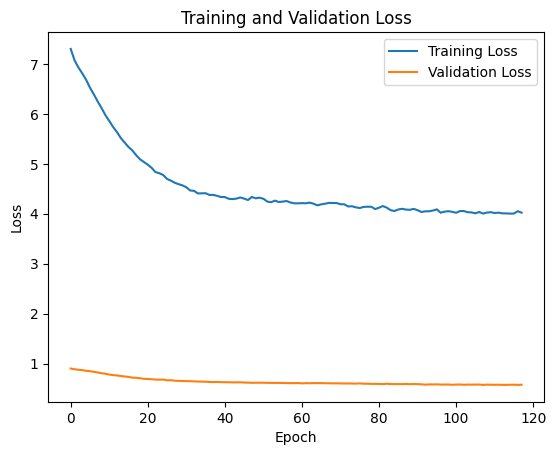

Average Time per Epoch: 24.23s
Average CPU Usage: 21.42%
Average Memory Usage: 3.94GB
Average GPU Usage: 0.04GB
Average GPU Utilization: 2.71%

Total Training Time: 2858.98s
Max CPU Usage: 30.25%
Max Memory Usage: 3.94GB
Max GPU Usage: 0.04GB
Max GPU Utilization: 3.50%


In [10]:
conv_size = oasis_adj_train.shape[2]
hidden_size = conv_size*conv_size

oasis_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
oasis_discriminator1 = EvoDiscriminator(conv_size, hidden_size).to(device)
oasis_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
oasis_discriminator2 = EvoDiscriminator(conv_size, hidden_size).to(device)

print(oasis_generator1)
print(oasis_discriminator1)
n_generator_param = oasis_generator1.count_parameters()
n_discriminator_param = oasis_discriminator1.count_parameters()
n_evograph_param = n_generator_param + n_discriminator_param
print(f"Total number of trainable parameters: {n_evograph_param*2}\n")

# Train model 
train_evograph(oasis_generator1, oasis_discriminator1, oasis_generator2, oasis_discriminator2,
            oasis_adj_train, oasis_adj_val, num_epochs=200, lr_d=0.001, lr_g=0.001, 
            step_size=200, gamma=0.5, patience=10, save_path="models/evograph_oasis")

Mean Squared Error between predicted (t1) and ground truth graphs (t0):  0.08086604


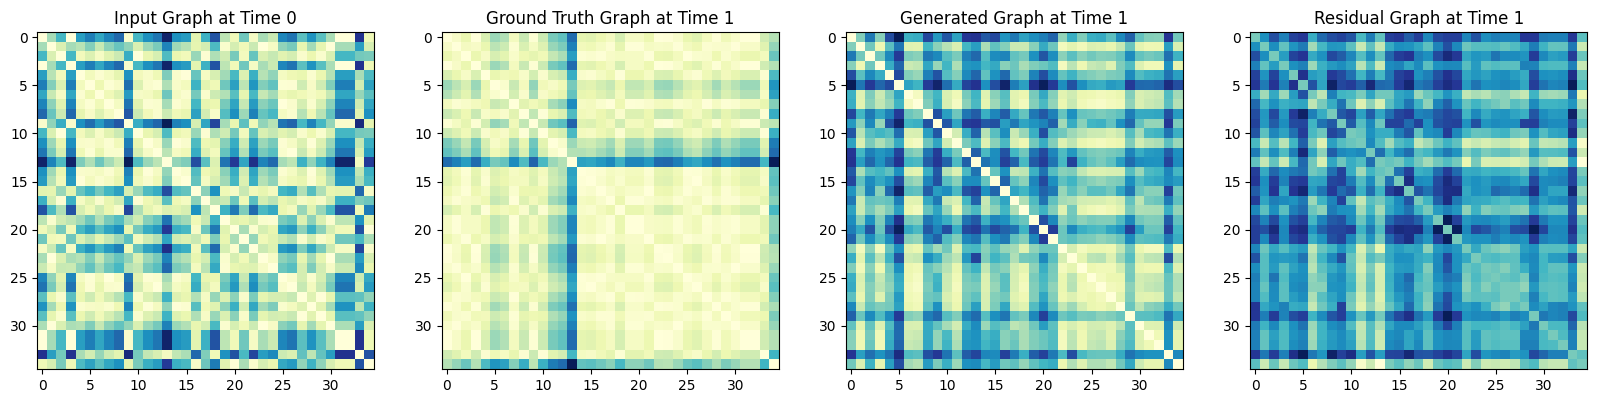

Mean Squared Error between predicted (t2) and ground truth graphs (t1):  0.51628095


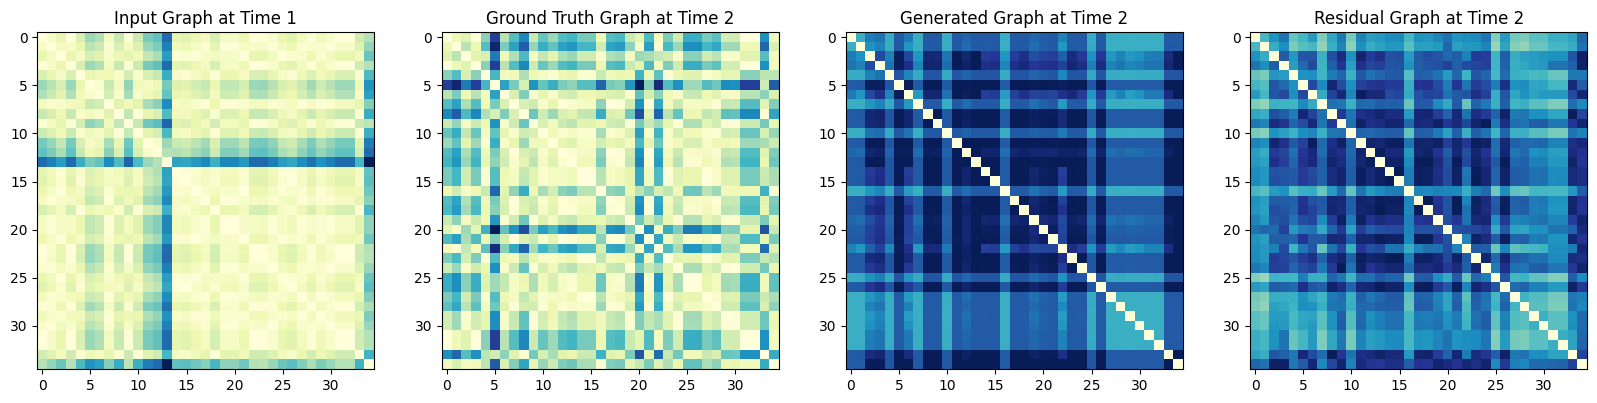

Mean Squared Error between ground truth graphs:  0.031859305


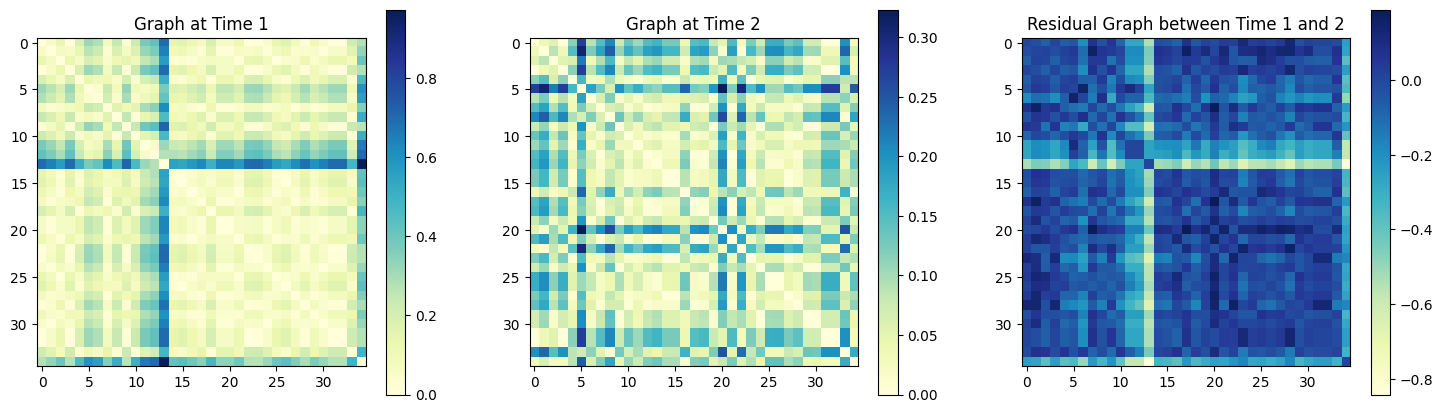

Mean Squared Error between generated graphs:  0.21255122


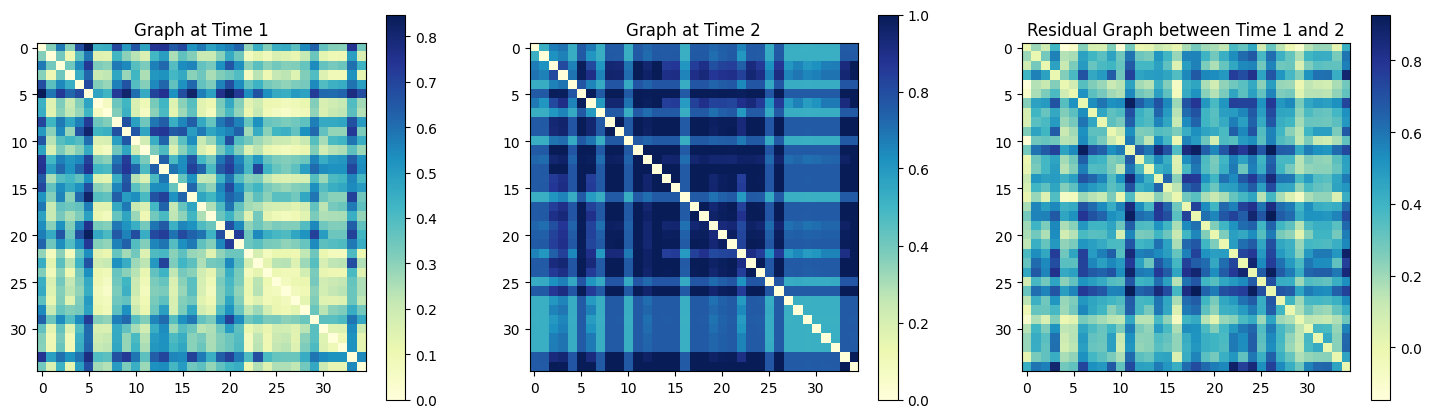

MAE:  0.34931168
Average Frobenius distance: 13.207893
Average Jaccard distance: 0.010084033613445342
Average MAE global efficiency: 0.005042016806722671
Average MAE local efficiency: 0.004736440030557398
Average MAE betweenness centrality: 0.08484356087034657
Average MAE eigenvector centrality: 0.04049673886432897


In [11]:
conv_size = oasis_adj_train.shape[2]
hidden_size = conv_size*conv_size

oasis_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
oasis_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
oasis_generator1.load_state_dict(torch.load('models/evograph_oasis_generator1.pth'))
oasis_generator2.load_state_dict(torch.load('models/evograph_oasis_generator2.pth'))


inference_evograph(oasis_generator1.to(device), oasis_generator2.to(device), oasis_adj_test.to(device), 0)
evaluate_evograph(oasis_generator1.to(device), oasis_generator2.to(device), oasis_adj_test.to(device))

## Simulated

#### 3-Fold CV

#### Simple Train-Test

In [12]:
conv_size = simulated_adj_train.shape[2]
hidden_size = conv_size*conv_size

simulated_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
simulated_discriminator1 = EvoDiscriminator(conv_size, hidden_size).to(device)
simulated_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
simulated_discriminator2 = EvoDiscriminator(conv_size, hidden_size).to(device)

print(simulated_generator1)
print(simulated_discriminator1)
n_generator_param = simulated_generator1.count_parameters()
n_discriminator_param = simulated_discriminator1.count_parameters()
n_evograph_param = n_generator_param + n_discriminator_param
print(f"Total number of trainable parameters: {n_evograph_param*2}\n")

# Train model 
train_evograph(simulated_generator1, simulated_discriminator1, simulated_generator2, simulated_discriminator2,
            simulated_adj_train, simulated_adj_val, num_epochs=200, lr_d=0.0001, lr_g=0.0001, 
            step_size=50, gamma=0.5, save_path="models/evograph_simulated")

EvoGenerator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
  (conv3): NNConv(1, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv33): BatchNorm(35)
)
EvoDiscriminator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
)
Total number of trainable parameters: 18492

Epoch 1:
  Training -> D1 Loss: 0.75050, G1 Loss: 3.09328, D2 Loss: 0.74597, G2 Loss: 3.14918
  Validation -> Loss: 0.7038, Genera

: 

Mean Squared Error between predicted (t1) and ground truth graphs (t0):  0.38802025


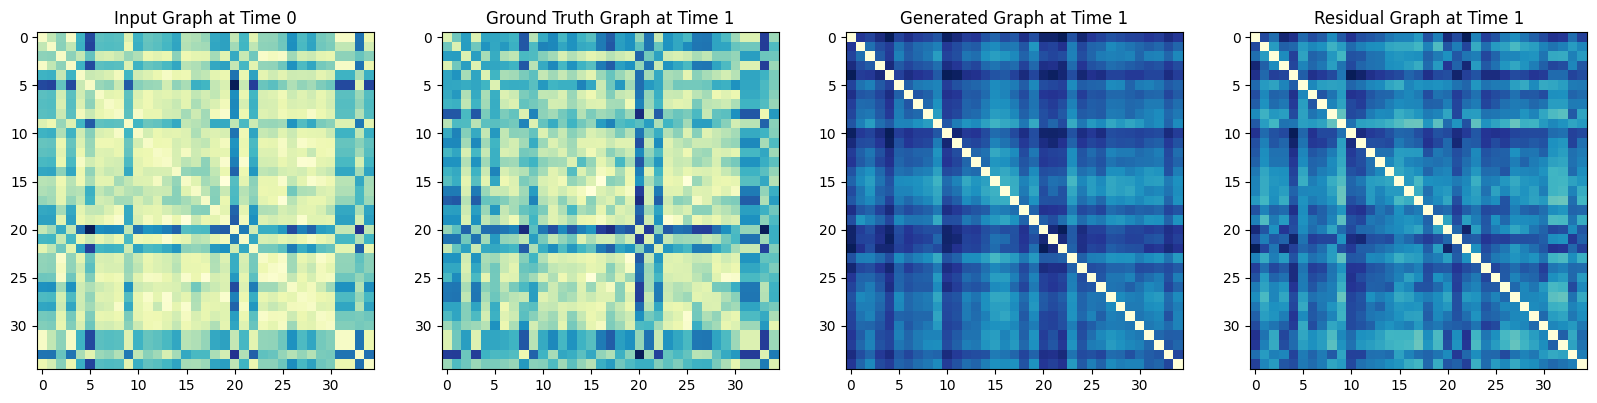

Mean Squared Error between predicted (t2) and ground truth graphs (t1):  0.016178012


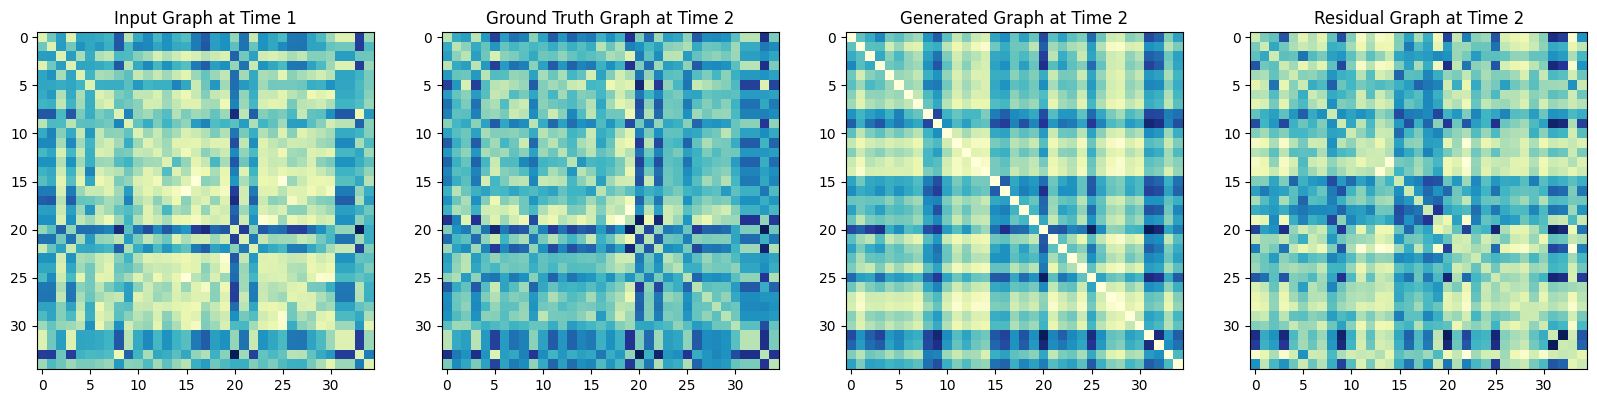

Mean Squared Error between ground truth graphs:  0.0036118329


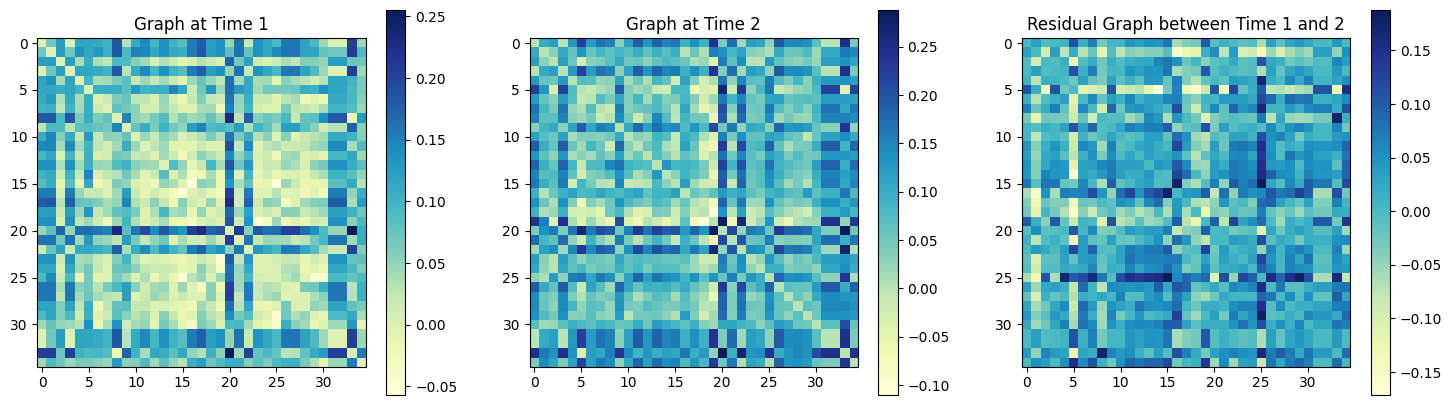

Mean Squared Error between generated graphs:  0.2783793


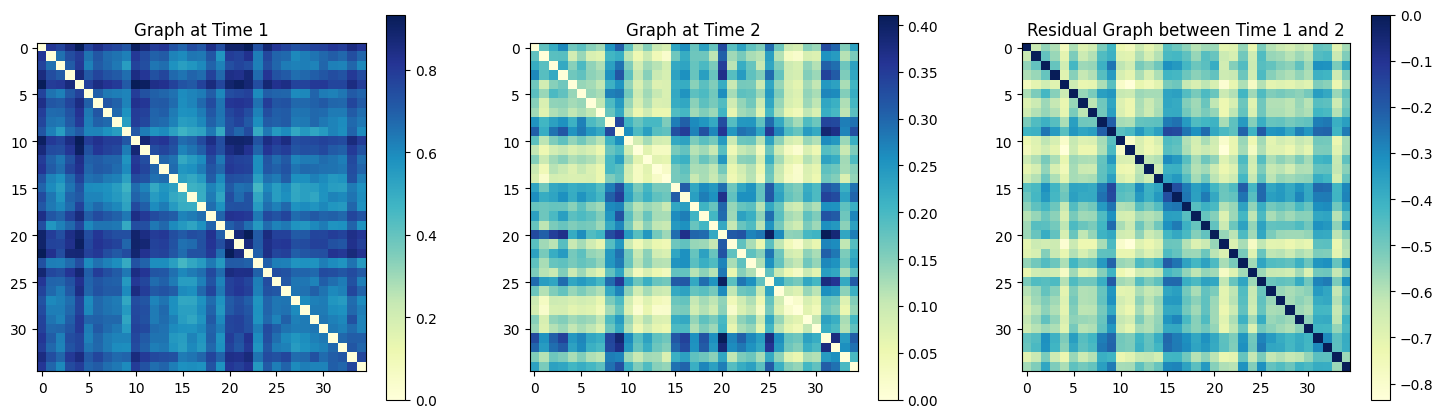

MAE:  0.38670516
Average Frobenius distance: 13.965091
Average Jaccard distance: 0.06239495798319328
Average MAE global efficiency: 0.0
Average MAE local efficiency: 0.0
Average MAE betweenness centrality: 0.24546473134708427
Average MAE eigenvector centrality: 0.03776981371953127


In [34]:
conv_size = simulated_adj_train.shape[2]
hidden_size = conv_size*conv_size

simulated_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
simulated_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
simulated_generator1.load_state_dict(torch.load('models/evograph_simulated_generator1.pth'))
simulated_generator2.load_state_dict(torch.load('models/evograph_simulated_generator2.pth'))


inference_evograph(simulated_generator1.to(device), simulated_generator2.to(device), simulated_adj_test.to(device), 0)
evaluate_evograph(simulated_generator1.to(device), simulated_generator2.to(device), simulated_adj_test.to(device))

## EMCI-AD

#### 3-Fold CV

#### Simple Train-Test

EvoGenerator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
  (conv3): NNConv(1, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv33): BatchNorm(35)
)
EvoDiscriminator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
)
Total number of trainable parameters: 18492



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1:
  Training -> D1 Loss: 0.75526, G1 Loss: 2.29954, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 0.5699, Generative Loss: 0.5699, Topological Loss: 296.5132
Time: 5.08s, CPU: 22.35%, Memory: 4.70GB, GPU: 0.03GB, GPU Util: 4.00%
Epoch 2:
  Training -> D1 Loss: 0.74365, G1 Loss: 2.28934, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 0.5658, Generative Loss: 0.5658, Topological Loss: 291.2614
Time: 5.08s, CPU: 15.85%, Memory: 4.70GB, GPU: 0.03GB, GPU Util: 7.00%
Epoch 3:
  Training -> D1 Loss: 0.73332, G1 Loss: 2.27438, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 0.5634, Generative Loss: 0.5634, Topological Loss: 292.6767
Time: 5.15s, CPU: 16.05%, Memory: 4.70GB, GPU: 0.03GB, GPU Util: 6.00%
Epoch 4:
  Training -> D1 Loss: 0.72689, G1 Loss: 2.27708, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 0.5601, Generative Loss: 0.5601, Topological Loss: 291.7540
Time: 5.15s, CPU: 31.15%, Memory: 4.70GB, GPU: 0.03GB, GPU Util: 5.00%
Epoch 5:
  T

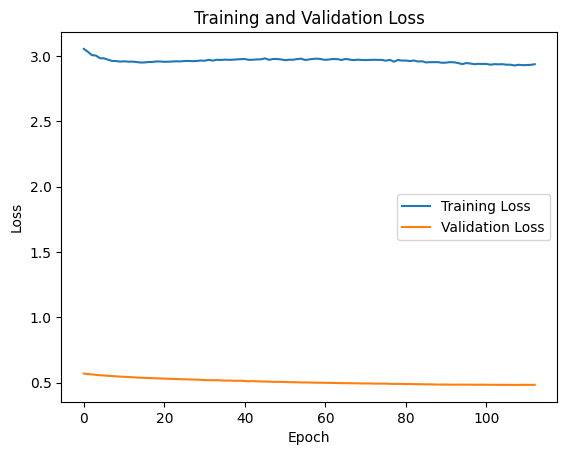

Average Time per Epoch: 5.23s
Average CPU Usage: 21.56%
Average Memory Usage: 4.70GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 5.18%

Total Training Time: 590.73s
Max CPU Usage: 34.00%
Max Memory Usage: 4.70GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 7.50%


In [35]:
conv_size = emci_adj_train.shape[2]
hidden_size = conv_size*conv_size

emci_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
emci_discriminator1 = EvoDiscriminator(conv_size, hidden_size).to(device)
emci_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
emci_discriminator2 = EvoDiscriminator(conv_size, hidden_size).to(device)

print(emci_generator1)
print(emci_discriminator1)
n_generator_param = emci_generator1.count_parameters()
n_discriminator_param = emci_discriminator1.count_parameters()
n_evograph_param = n_generator_param + n_discriminator_param
print(f"Total number of trainable parameters: {n_evograph_param*2}\n")

# Train model 
train_evograph(emci_generator1, emci_discriminator1, emci_generator2, emci_discriminator2,
            emci_adj_train, emci_adj_val, num_epochs=200, lr_d=0.0001, lr_g=0.0001, 
            step_size=100, gamma=0.5, save_path="models/evograph_emci")

Mean Squared Error between predicted (t1) and ground truth graphs (t0):  0.40640998


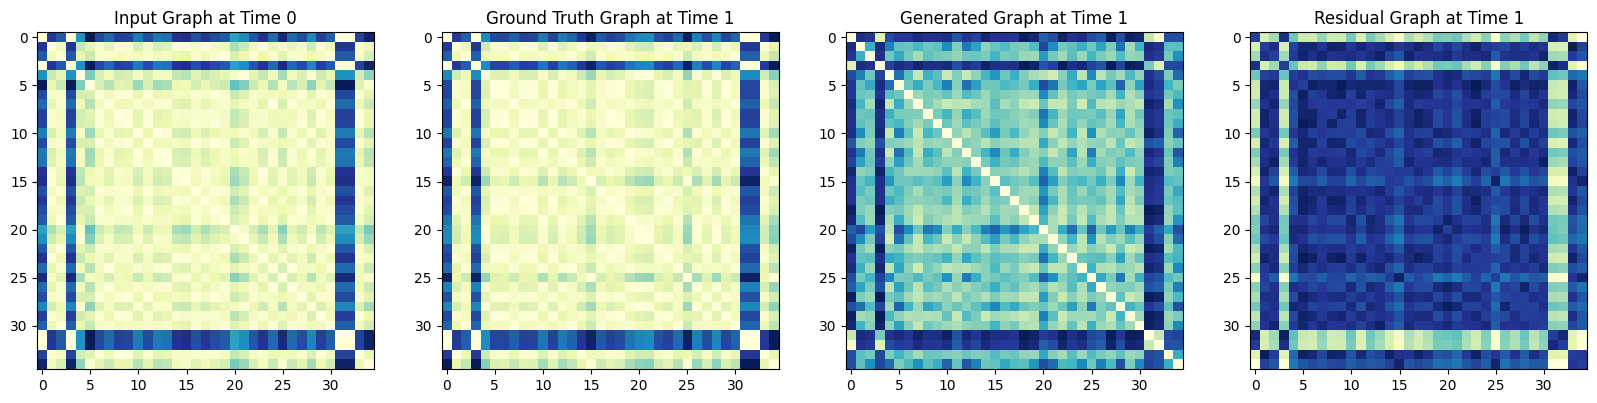

MAE:  0.45997122
Average Frobenius distance: 24.61286
Average Jaccard distance: 0.010084033613445342
Average MAE global efficiency: 0.005042016806722671
Average MAE local efficiency: 0.004736440030557398
Average MAE betweenness centrality: 0.09561494900990698
Average MAE eigenvector centrality: 0.030889933891801915


In [36]:
conv_size = emci_adj_train.shape[2]
hidden_size = conv_size*conv_size

emci_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
emci_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
emci_generator1.load_state_dict(torch.load('models/evograph_emci_generator1.pth'))
emci_generator2.load_state_dict(torch.load('models/evograph_emci_generator2.pth'))


inference_evograph(emci_generator1.to(device), emci_generator2.to(device), emci_adj_test.to(device), 0)
evaluate_evograph(emci_generator1.to(device), emci_generator2.to(device), emci_adj_test.to(device))

## SLIM160

#### Simple Train-Test

In [11]:
conv_size = slim160_adj_train.shape[2]
hidden_size = conv_size*conv_size

slim160_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
slim160_discriminator1 = EvoDiscriminator(conv_size, hidden_size).to(device)
slim160_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
slim160_discriminator2 = EvoDiscriminator(conv_size, hidden_size).to(device)

print(slim160_generator1)
print(slim160_discriminator1)
n_generator_param = slim160_generator1.count_parameters()
n_discriminator_param = slim160_discriminator1.count_parameters()
n_evograph_param = n_generator_param + n_discriminator_param
print(f"Total number of trainable parameters: {n_evograph_param*2}\n")

# Train model 
train_evograph(slim160_generator1, slim160_discriminator1, slim160_generator2, slim160_discriminator2,
            slim160_adj_train, slim160_adj_val, num_epochs=100, lr_d=0.001, lr_g=0.001, 
            step_size=50, gamma=0.1, save_path="models/evograph_slim160")

EvoGenerator(
  (conv1): NNConv(160, 160, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=25600, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(160)
  (conv2): NNConv(160, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=160, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
  (conv3): NNConv(1, 160, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=160, bias=True)
    (1): ReLU()
  ))
  (conv33): BatchNorm(160)
)
EvoDiscriminator(
  (conv1): NNConv(160, 160, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=25600, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(160)
  (conv2): NNConv(160, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=160, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
)
Total number of trainable parameters: 364492



OutOfMemoryError: CUDA out of memory. Tried to allocate 2.44 GiB. GPU 0 has a total capacty of 15.73 GiB of which 2.33 GiB is free. Process 1836966 has 13.40 GiB memory in use. Of the allocated memory 10.01 GiB is allocated by PyTorch, and 2.31 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF